# Problem Statement
Mobile game app developers often struggle with determining the optimal **price** for their games, as well as how to structure **in-app purchases (IAPs)** to balance profitability with user satisfaction With users becoming increasingly price-sensitive and many opting for free apps, finding the right price point is crucial for balancing revenue generation with download volume. While apps priced too high may reduce user downloads, pricing too low or free without a well-designed IAP strategy can limit revenue potential. 

This project leverages the 17K Apple App Store Strategy Games dataset to develop machine learning models that predict:
- The **price** of an app based on its features (e.g., genre, ratings, app size, release dates)
- The **average value of in-app purchases (IAP mean)** for a game to guide monetization strategy.

[🔗 View the dataset on Kaggle](https://www.kaggle.com/datasets/tristan581/17k-apple-app-store-strategy-games)


# Scope Refinement
While the initial goal was to predict app price based on metadata, EDA reveals that the dataset was heavily skewed as more than 83% of apps are free. This imbalance severely limited the model's ability to accurately predict price and reduced the practical value of the output. Hence, the project scope was refined to focus on predicting the average in-app purchase amount (IAPMean), as it is less skewed and provides more practical value for understanding app monetization strategies. This shift not only addresses the class imbalance but also better reflects modern monetization strategies used by game developers.

In [1]:
!pip install -r requirements.txt

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import random
from datetime import datetime
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import matplotlib as mpl   

# Preprocessing
from sklearn.preprocessing import (
    MultiLabelBinarizer, OneHotEncoder, LabelEncoder,
    normalize, StandardScaler
)
from sklearn import preprocessing

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_score, recall_score, f1_score
)
from sklearn import metrics

# Regressors
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Stats
from scipy import stats
from scipy.stats import randint, uniform, loguniform


In [3]:
#import dataset
games_df = pd.read_csv("appstore_games.csv")
games_df.columns = games_df.columns.str.strip().str.replace(' ', '')
games_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        17007 non-null  object 
 1   ID                         17007 non-null  int64  
 2   Name                       17007 non-null  object 
 3   Subtitle                   5261 non-null   object 
 4   IconURL                    17007 non-null  object 
 5   AverageUserRating          7561 non-null   float64
 6   UserRatingCount            7561 non-null   float64
 7   Price                      16983 non-null  float64
 8   In-appPurchases            7683 non-null   object 
 9   Description                17007 non-null  object 
 10  Developer                  17007 non-null  object 
 11  AgeRating                  17007 non-null  object 
 12  Languages                  16947 non-null  object 
 13  Size                       17006 non-null  flo

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# overview of the dataset
games_df.head(5)

,URL,ID,Name,Subtitle,IconURL,AverageUserRating,UserRatingCount,Price,In-appPurchases,Description,Developer,AgeRating,Languages,Size,PrimaryGenre,Genres,OriginalReleaseDate,CurrentVersionReleaseDate
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


# Data Cleaning

In [6]:
# Remove unnecessary columns
games_df = games_df.drop(columns=['Description', 'ID', 'URL', 'IconURL', 'Name'])

In [7]:
missing_percent = games_df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].round(2)

print("Percentage of missing values per column:\n")
print(missing_percent.sort_values(ascending=False))

Percentage of missing values per column:

Subtitle             69.07
AverageUserRating    55.54
UserRatingCount      55.54
In-appPurchases      54.82
Languages             0.35
Price                 0.14
Size                  0.01
dtype: float64


We first addressed the columns with the highest proportion of missing values: `AverageUserRating`, `UserRatingCount`, and `In-appPurchases`.

- **AverageUserRating**: Missing values likely indicate that the app has not received any user ratings. Since this column is used as a feature in our price prediction model, we dropped rows where this value is missing to avoid introducing noise or assumptions.

- **UserRatingCount**: Like `AverageUserRating`, missing `UserRatingCount` likely means the app hasn't received any ratings. These missing values are removed with `AverageUserRating` to ensure consistency.

- **In-appPurchases**: Missing values suggest that as the app not offering any in-app purchases. Instead of dropping these rows, we replaced `NaN` with different columns:
  - `IAP_Count`: Number of in-app purchase items (0 if none)
  - `IAP_Mean`: Average price of IAPs (0 if none)


In [8]:

# Fill NaN with empty strings to safely parse
iap_clean = games_df['In-appPurchases'].fillna('')

# Define a function to extract count, mean, and binary flag
def extract_iap_features(iap_str):
    if not iap_str.strip():  
        return pd.Series([0, 0.0]) 

    try:
        prices = [float(p.strip()) for p in iap_str.split(',') if p.strip()]
        count = len(prices)
        mean = np.mean(prices)
        return pd.Series([count, mean])
    except:
        return pd.Series([0, 0.0])

# Apply the function to create columns
games_df[['IAPCount', 'IAPMean']] = iap_clean.apply(extract_iap_features)

# Drop original In-appPurchases column
games_df = games_df.drop(['In-appPurchases'], axis=1)

In [9]:
# Drop nan values for AverageUserRating and UserRatingCount
games_df = games_df.dropna(subset=['AverageUserRating'])
games_df = games_df[games_df['UserRatingCount'] > 0]

In [10]:
#Fill in data with mean or mode
games_df['Languages'].fillna(games_df['Languages'].value_counts().index[0],inplace= True)
games_df['Size'].fillna(games_df['Size'].mean(),inplace=True)
games_df['Price'].fillna(games_df['Price'].value_counts().index[0],inplace= True)


In [11]:
# Add column to count number of language
games_df['LanguageCount'] = games_df['Languages'].fillna('').apply(
    lambda x: len([lang.strip() for lang in x.split(',') if lang.strip()])
)

In [12]:
games_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 7561 entries, 0 to 16993
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Subtitle                   2724 non-null   object 
 1   AverageUserRating          7561 non-null   float64
 2   UserRatingCount            7561 non-null   float64
 3   Price                      7561 non-null   float64
 4   Developer                  7561 non-null   object 
 5   AgeRating                  7561 non-null   object 
 6   Languages                  7561 non-null   object 
 7   Size                       7561 non-null   float64
 8   PrimaryGenre               7561 non-null   object 
 9   Genres                     7561 non-null   object 
 10  OriginalReleaseDate        7561 non-null   object 
 11  CurrentVersionReleaseDate  7561 non-null   object 
 12  IAPCount                   7561 non-null   float64
 13  IAPMean                    7561 non-null   float64
 

# Data Visualisation

### Price

First, we try to find out some basic statistic of the price.​



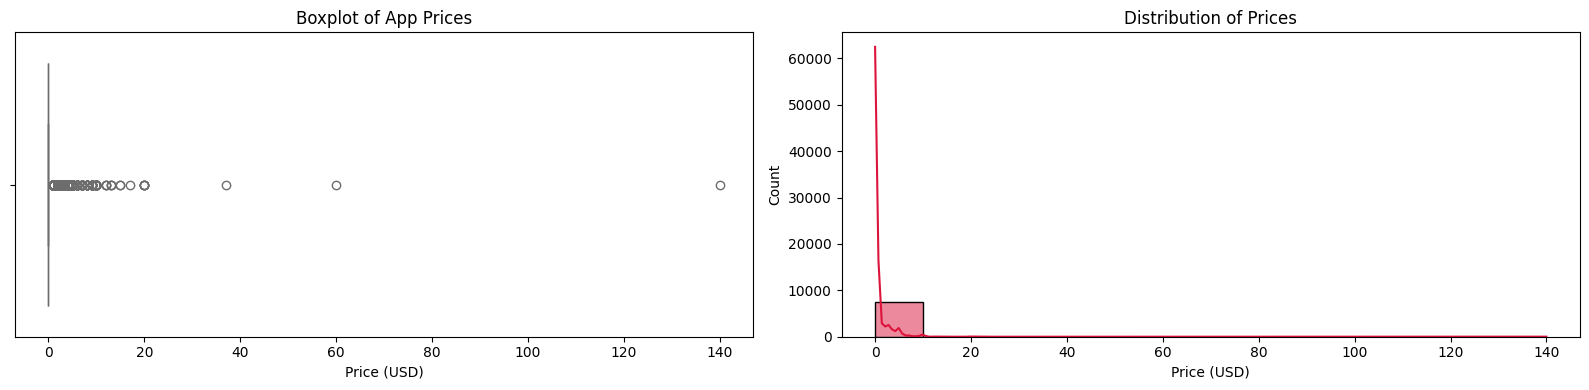

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Boxplot
sns.boxplot(x=games_df['Price'], color='salmon', ax=axes[0])
axes[0].set_title('Boxplot of App Prices')
axes[0].set_xlabel('Price (USD)')

# Distribution plot
sns.histplot(games_df['Price'], kde=True, color='crimson', ax=axes[1])
axes[1].set_title('Distribution of Prices')
axes[1].set_xlabel('Price (USD)')

plt.tight_layout()
plt.show()

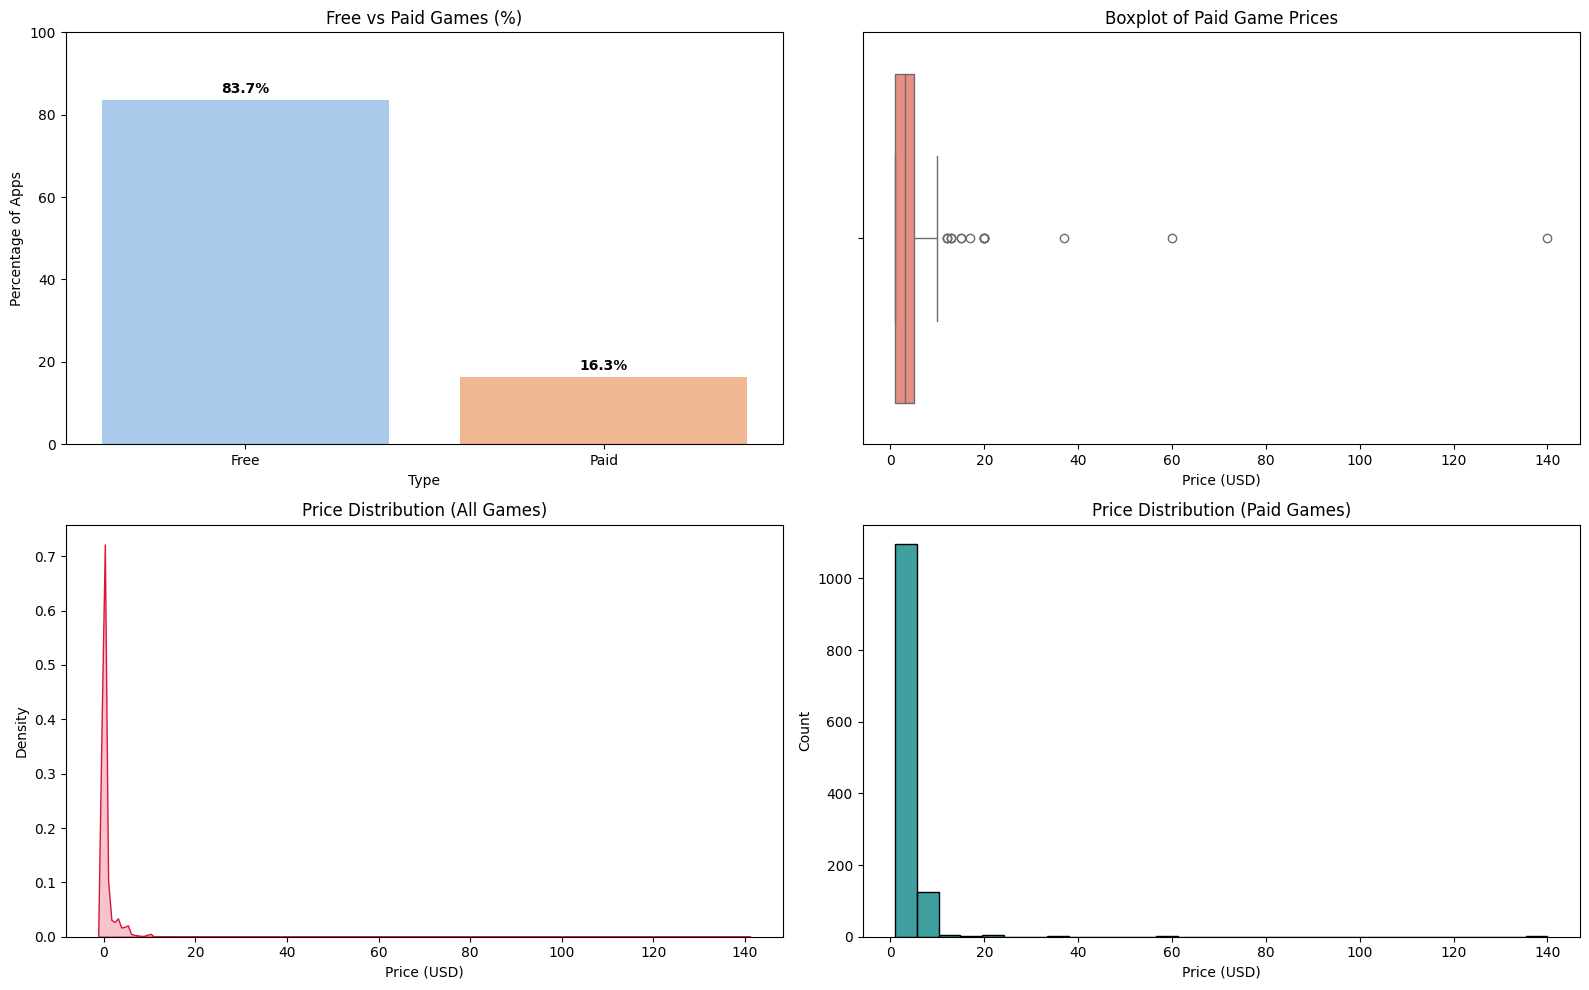

In [14]:
# Create filtered datasets
free_paid = games_df.copy()
free_paid['IsFree'] = free_paid['Price'] == 0
paid_games = games_df[games_df['Price'] > 0]
all_prices = games_df['Price']
paid_prices = paid_games['Price']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Compute percentage of free vs paid
price_group = free_paid['IsFree'].value_counts(normalize=True).rename({True: 'Free', False: 'Paid'}) * 100
price_df = price_group.reset_index()
price_df.columns = ['Type', 'Percentage']

# Plot 1: Bar chart of Free vs Paid
sns.barplot(x='Type', y='Percentage', data=price_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Free vs Paid Games (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)

# Add labels on top of bars
for i, row in price_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', va='bottom', fontweight='bold')

# Plot 2: Boxplot of Paid Games
sns.boxplot(x=paid_prices, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of Paid Game Prices')
axes[0, 1].set_xlabel('Price (USD)')

# Plot 3: Line chart (KDE) of All Prices
sns.kdeplot(all_prices, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('Price Distribution (All Games)')
axes[1, 0].set_xlabel('Price (USD)')

# Plot 4: Histogram of Paid Prices
sns.histplot(paid_prices, ax=axes[1, 1], color='teal', bins=30, kde=False)
axes[1, 1].set_title('Price Distribution (Paid Games)')
axes[1, 1].set_xlabel('Price (USD)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [15]:
# Apply log transform
games_df['LogPrice'] = np.log1p(games_df['Price'])

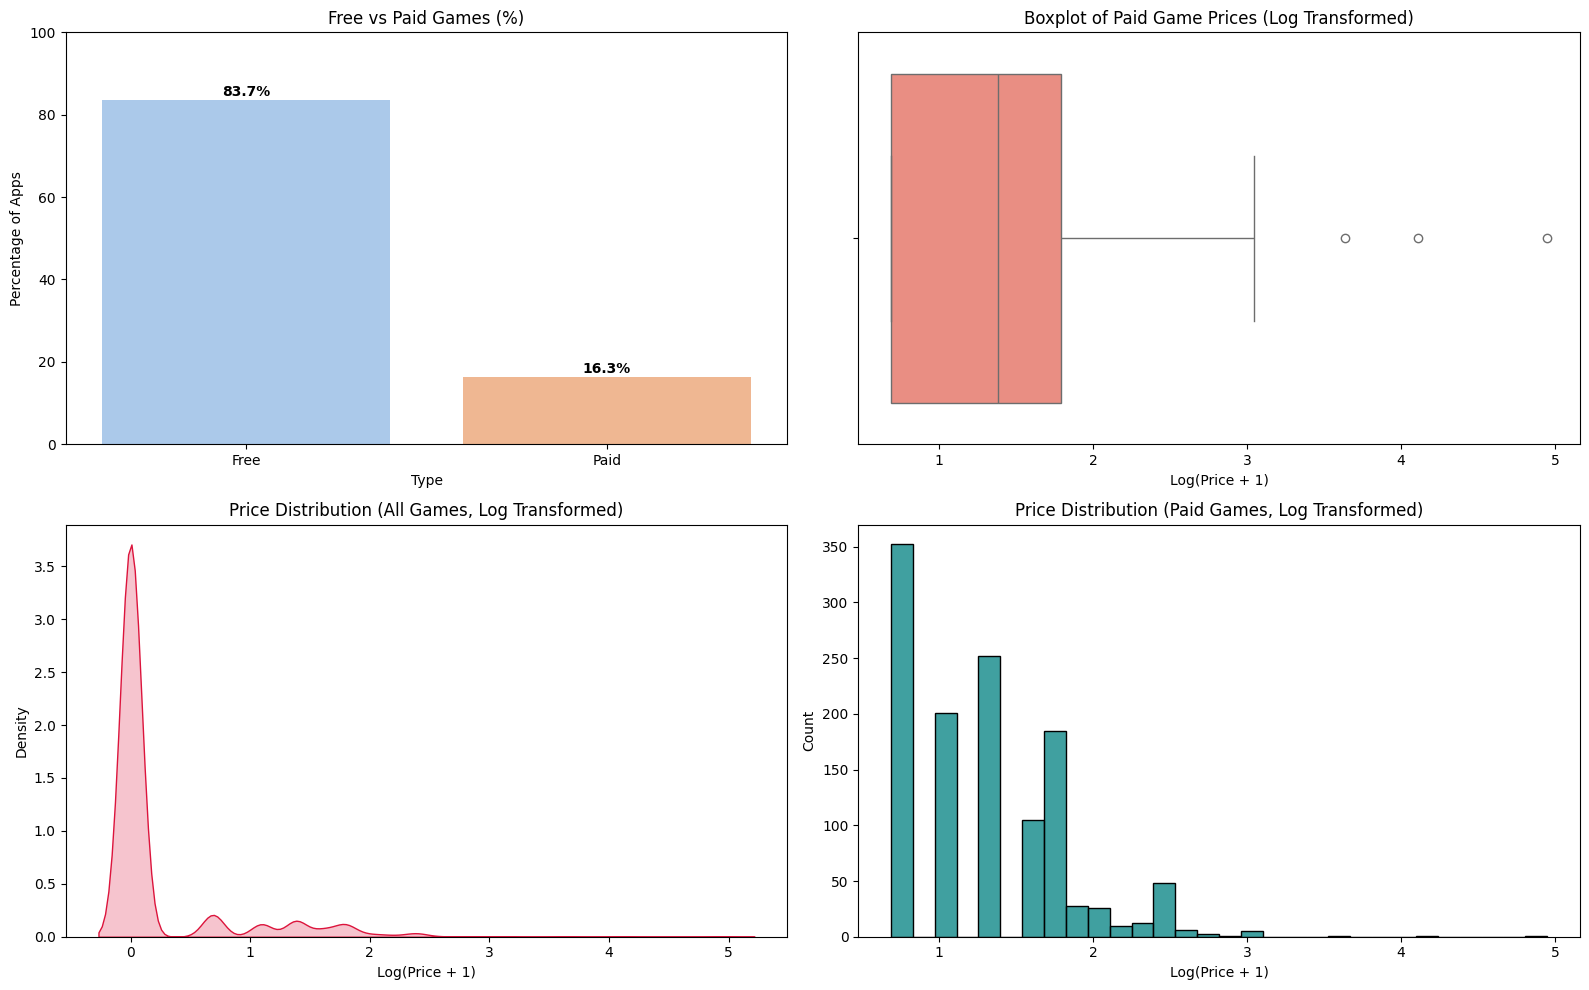

In [16]:

# Create derived columns
free_paid = games_df.copy()
free_paid['IsFree'] = free_paid['LogPrice'] == 0
paid_games = free_paid[~free_paid['IsFree']]
all_prices = free_paid['LogPrice']
paid_prices = paid_games['LogPrice']

# Create Free vs Paid percentage dataframe
price_group = free_paid['IsFree'].value_counts(normalize=True).rename({True: 'Free', False: 'Paid'}) * 100
price_df = price_group.reset_index()
price_df.columns = ['Type', 'Percentage']

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Bar chart - Free vs Paid (%)
sns.barplot(x='Type', y='Percentage', data=price_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Free vs Paid Games (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)
for i, row in price_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', fontweight='bold')

# Plot 2: Boxplot - LogPrice of Paid Games
sns.boxplot(x=paid_prices, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of Paid Game Prices (Log Transformed)')
axes[0, 1].set_xlabel('Log(Price + 1)')

# Plot 3: KDE - LogPrice for All Games
sns.kdeplot(all_prices, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('Price Distribution (All Games, Log Transformed)')
axes[1, 0].set_xlabel('Log(Price + 1)')

# Plot 4: Histogram - LogPrice for Paid Games
sns.histplot(paid_prices, ax=axes[1, 1], color='teal', bins=30)
axes[1, 1].set_title('Price Distribution (Paid Games, Log Transformed)')
axes[1, 1].set_xlabel('Log(Price + 1)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



### Age Rating

We try to find out whether age rating affects the price and IAPMean of games_df, by comparing the mean price and IAP of different categories of age rating.

The mean price for different categories of age rating:

In [17]:

# get mean price of each age rating category
age_price = games_df.groupby("AgeRating")["Price"].mean().reset_index()
age_price

,AgeRating,Price
0,12+,0.892041
1,17+,0.300104
2,4+,0.472266
3,9+,0.634654


In [18]:
age_price.describe()

,Price
count,4.000000
mean,0.574766
std,0.251790
min,0.300104
25%,0.429225
50%,0.553460
75%,0.699000
max,0.892041


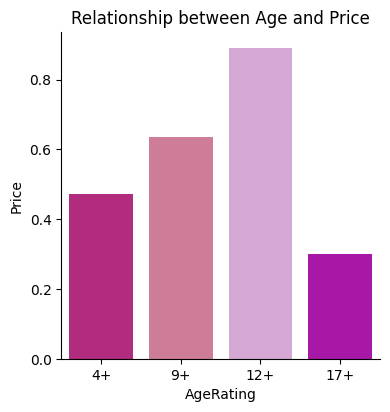

In [19]:
# assign different colours to the bars
palette = ["plum","m","mediumvioletred","palevioletred"]  

# arrange age in ascending order
order = ['4+', '9+', '12+', '17+']

# generate bar graph
age_rating = sns.catplot(x="AgeRating",y="Price", data=age_price, kind="bar", palette=palette, hue="AgeRating", dodge=False,height=4, aspect=1,order=order)
plt.title('Relationship between Age and Price', fontsize = 12)
plt.show()

We can see from the bar graph that the average price of games_df rose from 4+ to 9+, but showed an inverse relationship with age rating starting at 9+. The average price was the highest at age rating 9+ which is around 3 times higher than the other 3 categories.

In [20]:
# get mean price of each age rating category
age_IAP = games_df.groupby("AgeRating")["IAPMean"].mean().reset_index()
age_IAP

,AgeRating,IAPMean
0,12+,9.424213
1,17+,6.988903
2,4+,3.371805
3,9+,7.970326


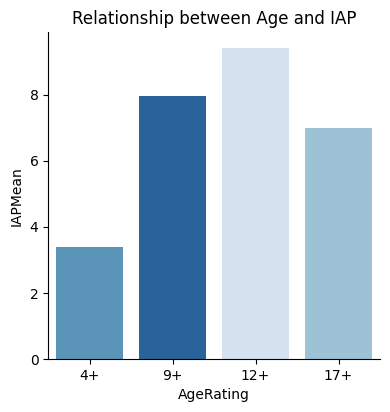

In [21]:
# assign different colours to the bars
palette = sns.color_palette("Blues", n_colors=4)

# generate bar graph
age_rating = sns.catplot(x="AgeRating",y="IAPMean", data=age_IAP, kind="bar", palette=palette, hue="AgeRating", dodge=False, height=4, aspect=1,order=order)
plt.title('Relationship between Age and IAP', fontsize = 12)
plt.show()

### Languages

We try to find out whether number of languages affects the price of games_df.


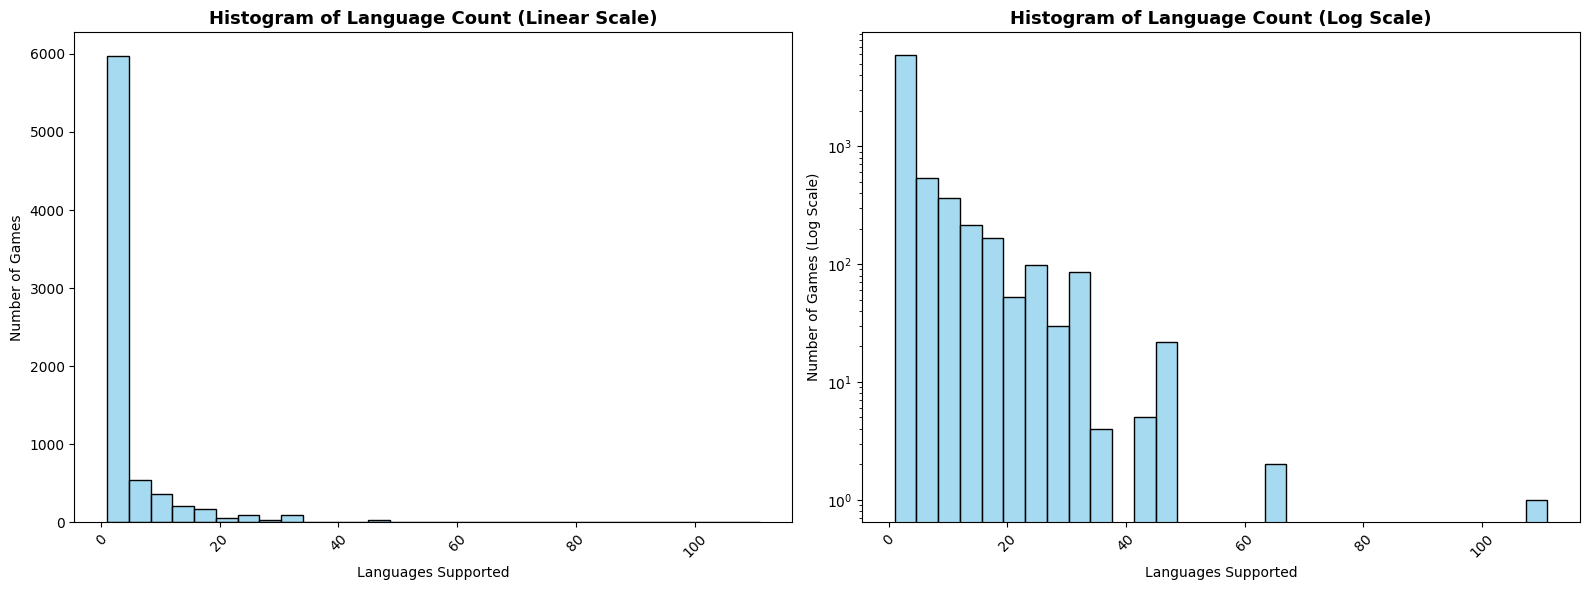

In [22]:
# Count number of apps by language count
lang_count_dist = games_df['LanguageCount'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram - Linear Scale
sns.histplot(games_df['LanguageCount'], bins=30, kde=False, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Language Count (Linear Scale)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Languages Supported')
axes[0].set_ylabel('Number of Games')
axes[0].tick_params(axis='x', rotation=45)

# Histogram - Log Scale
sns.histplot(games_df['LanguageCount'], bins=30, kde=False, color='skyblue', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Histogram of Language Count (Log Scale)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Languages Supported')
axes[1].set_ylabel('Number of Games (Log Scale)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [23]:
games_df["LanguageCount"].describe()

count    7561.000000
mean        3.818675
std         6.525615
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       111.000000
Name: LanguageCount, dtype: float64

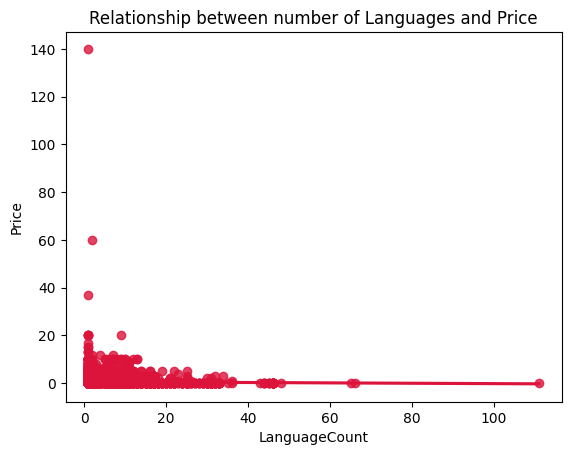

In [24]:
# create a regplot(scatter plot and the fitting line)
sns.regplot(x='LanguageCount', y='Price', data=games_df, color='crimson')
plt.title("Relationship between number of Languages and Price")
plt.show()

From the scatter plot above, we observe a very flat declining line. We can say that there is a very weak inverse relationship between price and number of languages

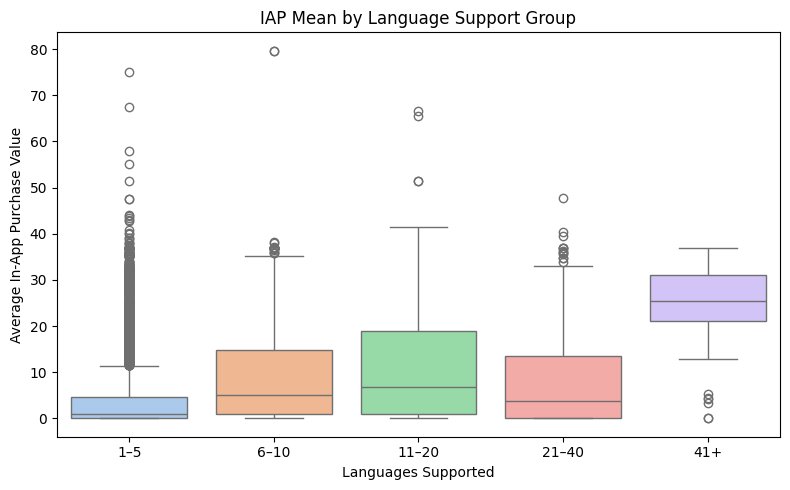

In [25]:
# Create bins
games_df['Lang_Bin'] = pd.cut(games_df['LanguageCount'], bins=[0, 5, 10, 20, 40, 100], labels=['1–5', '6–10', '11–20', '21–40', '41+'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='Lang_Bin', y='IAPMean', data=games_df, palette='pastel')
plt.title('IAP Mean by Language Support Group')
plt.xlabel('Languages Supported')
plt.ylabel('Average In-App Purchase Value')
plt.tight_layout()
plt.show()


As the number of supported languages increases, the median in-app purchase value (IAP Mean) tends to increase. While there is a general upward trend in IAP Mean as language support increases, the relationship is not strictly linear.


### Average User Rating

In [26]:

print(games_df['AverageUserRating'].describe())

count    7561.000000
mean        4.060905
std         0.751428
min         1.000000
25%         3.500000
50%         4.500000
75%         4.500000
max         5.000000
Name: AverageUserRating, dtype: float64


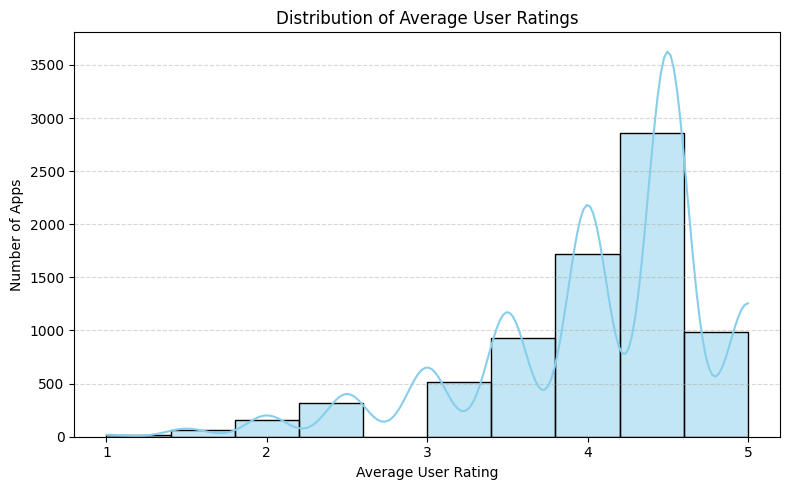

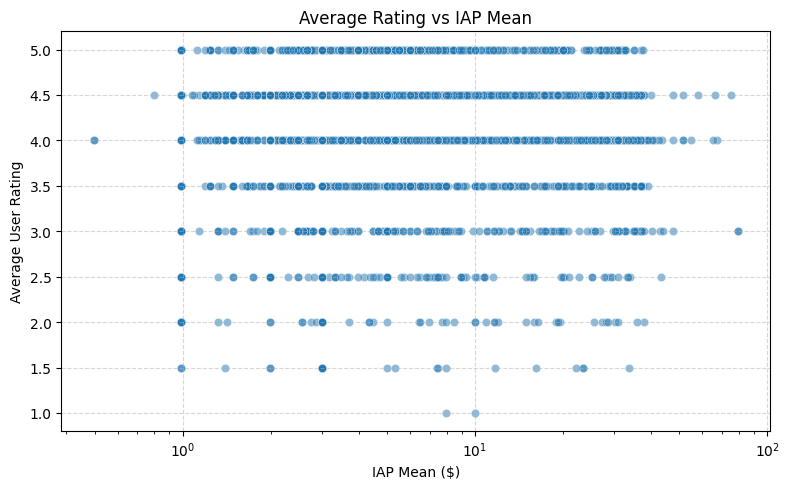

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(
    games_df['AverageUserRating'].dropna(),
    bins=10,  
    kde=True,      color='skyblue'
)

plt.title('Distribution of Average User Ratings')
plt.xlabel('Average User Rating')
plt.ylabel('Number of Apps')
plt.xticks(ticks=[1, 2, 3, 4, 5]) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.scatterplot(x='IAPMean', y='AverageUserRating', data=games_df, alpha=0.5)

plt.title('Average Rating vs IAP Mean')
plt.xlabel('IAP Mean ($)')
plt.ylabel('Average User Rating')
plt.xscale('log')  # IAPMean likely skewed, so log scale helps
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [28]:
print(games_df.columns)

Index(['Subtitle', 'AverageUserRating', 'UserRatingCount', 'Price',
       'Developer', 'AgeRating', 'Languages', 'Size', 'PrimaryGenre', 'Genres',
       'OriginalReleaseDate', 'CurrentVersionReleaseDate', 'IAPCount',
       'IAPMean', 'LanguageCount', 'LogPrice', 'Lang_Bin'],
      dtype='object')




### Original and Current Version Release Date 

In [29]:
# Convert to datetime format
games_df['OriginalReleaseDate'] = pd.to_datetime(games_df['OriginalReleaseDate'], dayfirst=True, errors='coerce')
games_df['CurrentVersionReleaseDate'] = pd.to_datetime(games_df['CurrentVersionReleaseDate'], dayfirst=True, errors='coerce')

# Extract the year
games_df['OriginalReleaseYear'] = games_df['OriginalReleaseDate'].dt.year
games_df['CurrentVersionReleaseYear'] = games_df['CurrentVersionReleaseDate'].dt.year


We extracted the years from the dates.

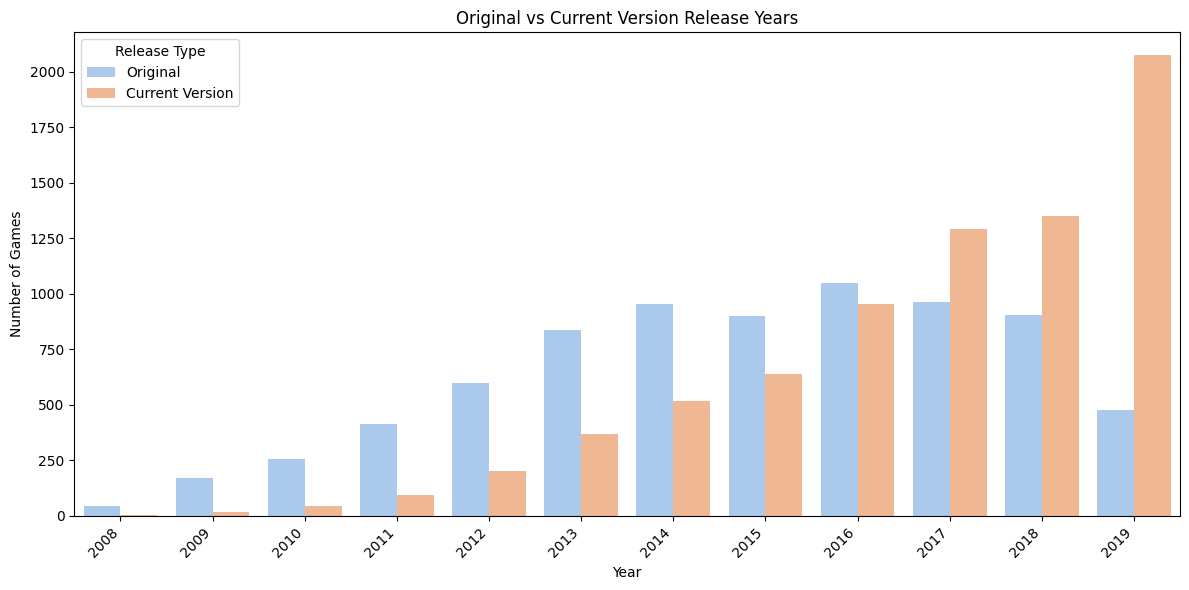

In [30]:
# Melt the year columns into one
release_years = pd.melt(
    games_df,
    id_vars=[],  
    value_vars=['OriginalReleaseYear', 'CurrentVersionReleaseYear'],
    var_name='ReleaseType',
    value_name='Year'
)

# Rename values
release_years['ReleaseType'] = release_years['ReleaseType'].replace({
    'OriginalReleaseYear': 'Original',
    'CurrentVersionReleaseYear': 'Current Version'
})

plt.figure(figsize=(12, 6))
sns.countplot(data=release_years, x='Year', hue='ReleaseType', palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.title('Original vs Current Version Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.legend(title='Release Type')
plt.tight_layout()
plt.show()

In [31]:
# Calculate the means 
org_year_mean = games_df.groupby("OriginalReleaseYear")["Price"].mean().reset_index()
cur_year_mean = games_df.groupby("CurrentVersionReleaseYear")["Price"].mean().reset_index()

# Rename columns
org_year_mean.columns = ['Year', 'OriginalMeanPrice']
cur_year_mean.columns = ['Year', 'CurrentMeanPrice']

# Merge the two DataFrames on 'Year'
price_comparison = pd.merge(org_year_mean, cur_year_mean, on='Year', how='outer').sort_values('Year')
price_comparison

,Year,OriginalMeanPrice,CurrentMeanPrice
0,2008,1.494318,0.000000
1,2009,0.926163,0.058235
2,2010,1.109804,0.129783
3,2011,0.824684,0.207604
4,2012,0.648344,0.174000
5,2013,0.680970,0.162527
6,2014,0.548283,0.146531
7,2015,0.541860,0.567094
8,2016,0.475349,0.671532
9,2017,0.438631,0.703315


We computed the mean price for each year.

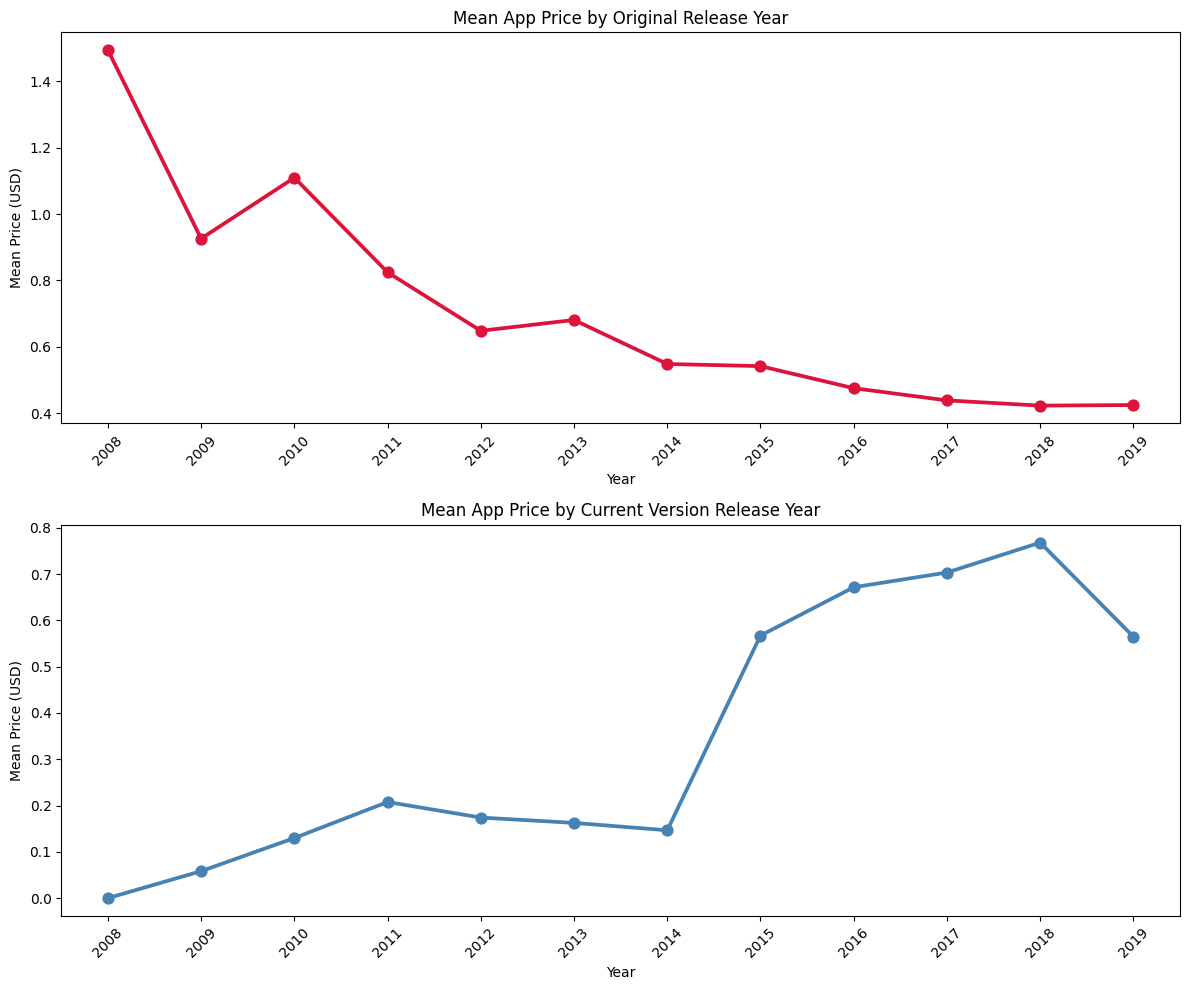

In [32]:
# Create 2x1 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False)

# Original Release Year Plot
sns.pointplot(data=org_year_mean, x='Year', y='OriginalMeanPrice', ax=axes[0], color='crimson')
axes[0].set_title("Mean App Price by Original Release Year")
axes[0].set_ylabel("Mean Price (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Current Version Release Year Plot
sns.pointplot(data=cur_year_mean, x='Year', y='CurrentMeanPrice', ax=axes[1], color='steelblue')
axes[1].set_title("Mean App Price by Current Version Release Year")
axes[1].set_ylabel("Mean Price (USD)")
axes[1].set_xlabel("Year")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [33]:
# Calculate the means 
org_year_mean = games_df.groupby("OriginalReleaseYear")["IAPMean"].mean().reset_index()
cur_year_mean = games_df.groupby("CurrentVersionReleaseYear")["IAPMean"].mean().reset_index()

# Rename columns
org_year_mean.columns = ['Year', 'OriginalMeanIAP']
cur_year_mean.columns = ['Year', 'CurrentMeanIAP']

# Merge the two DataFrames on 'Year'
price_comparison = pd.merge(org_year_mean, cur_year_mean, on='Year', how='outer').sort_values('Year')

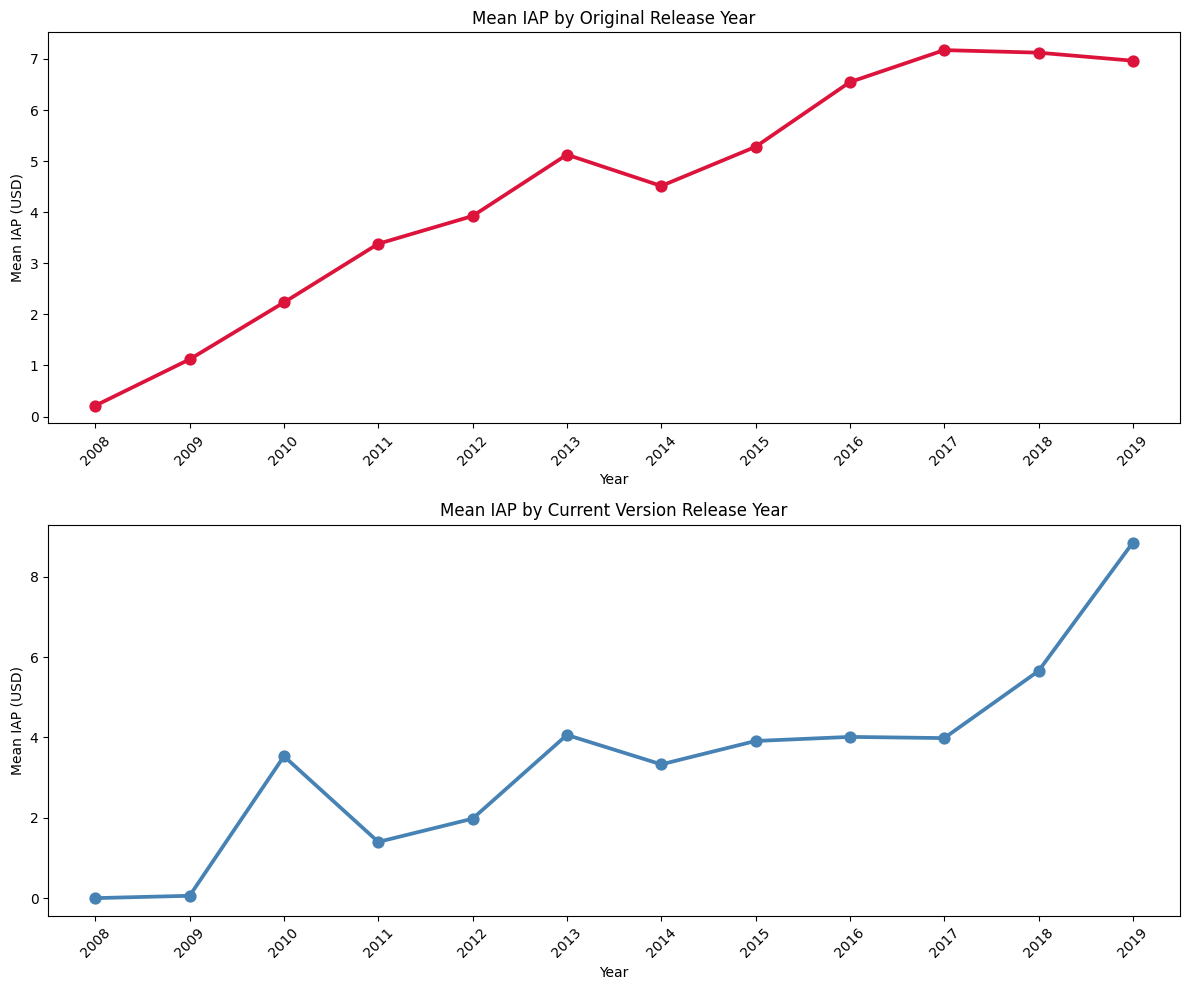

In [34]:
# Create 2x1 subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False)

# Original Release Year Plot
sns.pointplot(data=org_year_mean, x='Year', y='OriginalMeanIAP', ax=axes[0], color='crimson')
axes[0].set_title("Mean IAP by Original Release Year")
axes[0].set_ylabel("Mean IAP (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Current Version Release Year Plot
sns.pointplot(data=cur_year_mean, x='Year', y='CurrentMeanIAP', ax=axes[1], color='steelblue')
axes[1].set_title("Mean IAP by Current Version Release Year")
axes[1].set_ylabel("Mean IAP (USD)")
axes[1].set_xlabel("Year")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Primary Genre

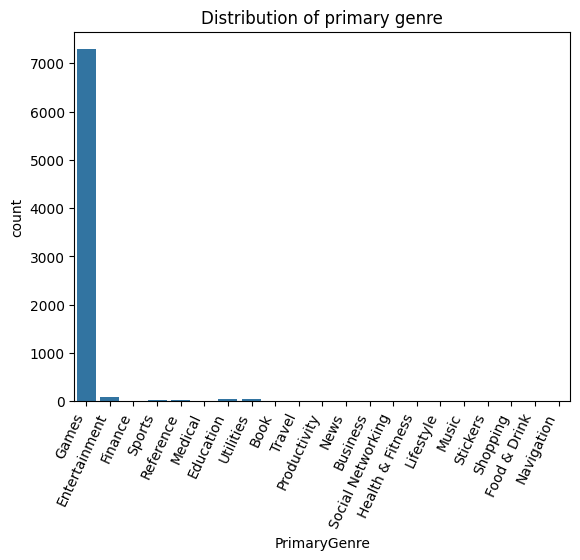

In [35]:
# find the distribution of primary genre
sns.countplot(x="PrimaryGenre",data=games_df,)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Distribution of primary genre")
plt.show()

In [36]:
# find out the mean price for each primary genre, using groupby()
mean_ge = games_df.groupby("PrimaryGenre")["Price"].mean().reset_index()
mean_ge.head()

,PrimaryGenre,Price
0,Book,0.000000
1,Business,4.995000
2,Education,2.104130
3,Entertainment,0.216196
4,Finance,17.498750


Above are the mean price for each primary genre.

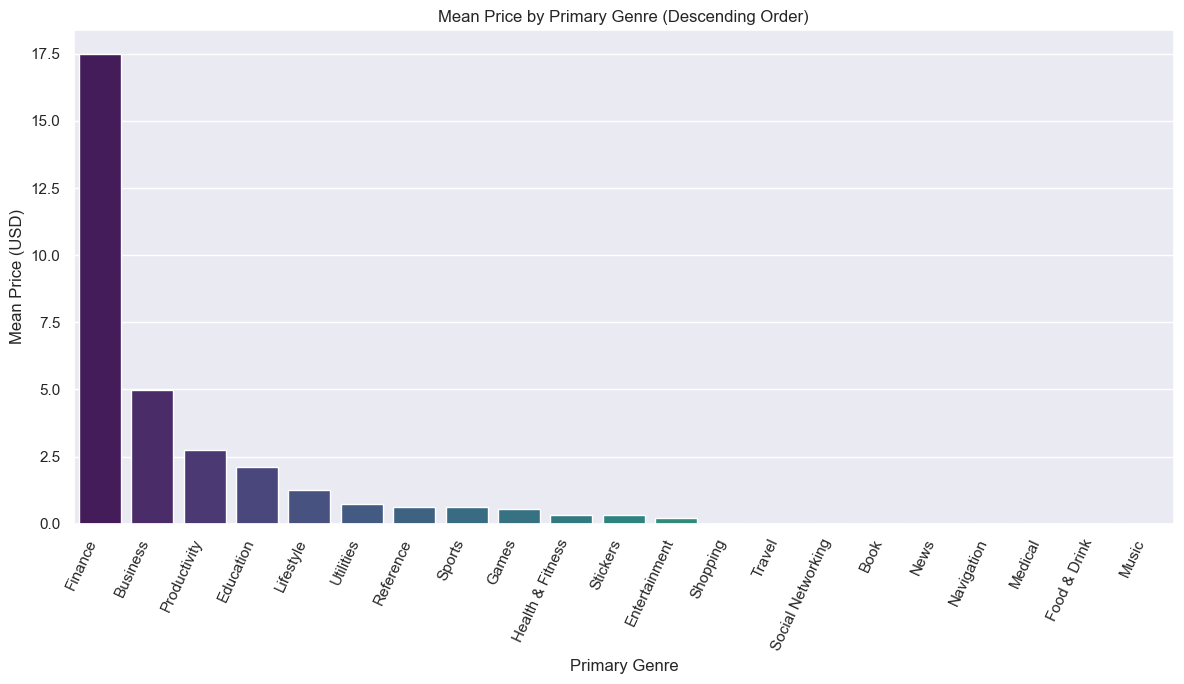

In [37]:

# Sort the data by mean price descending
mean_ge_sorted = mean_ge.sort_values(by="Price", ascending=False)

sns.set(rc={'figure.figsize': (12, 7)})

# plot the graph of all genres
ax = sns.barplot(x="PrimaryGenre", y="Price", data=mean_ge_sorted, palette="viridis")

plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Mean Price by Primary Genre (Descending Order)")
plt.ylabel("Mean Price (USD)")
plt.xlabel("Primary Genre")
plt.tight_layout()
plt.show()

For primary genre, from the graph, apps of business have highest price (around $5), and out of 21 primary genres, 9 are free.

In [38]:
# find out the mean IAp for each primary genre, using groupby()
mean_iap_ge = games_df.groupby("PrimaryGenre")["IAPMean"].mean().reset_index()
mean_iap_ge.head()

,PrimaryGenre,IAPMean
0,Book,6.520000
1,Business,5.995000
2,Education,1.686884
3,Entertainment,2.326486
4,Finance,14.617778


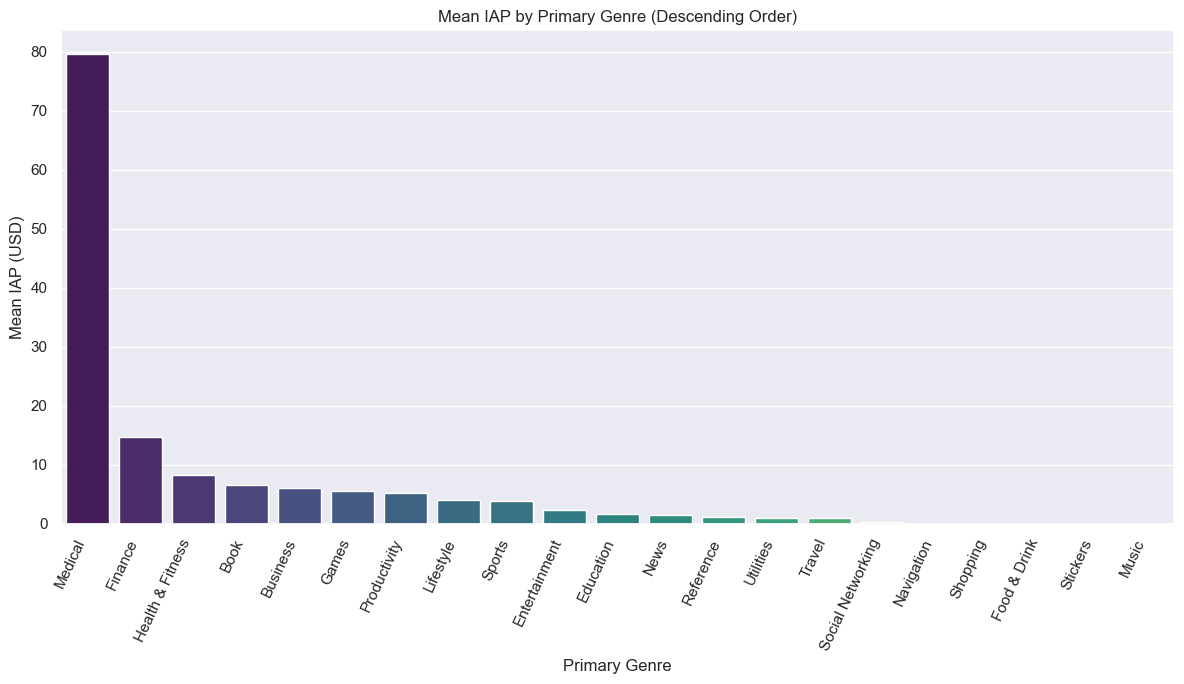

In [39]:
# Sort the data by mean IAP descending
mean_iap_ge_sorted = mean_iap_ge.sort_values(by="IAPMean", ascending=False)

sns.set(rc={'figure.figsize': (12, 7)})

# plot the graph of all genres
ax = sns.barplot(x="PrimaryGenre", y="IAPMean", data=mean_iap_ge_sorted, palette="viridis")

plt.xticks(rotation=65, horizontalalignment='right')
plt.title("Mean IAP by Primary Genre (Descending Order)")
plt.ylabel("Mean IAP (USD)")
plt.xlabel("Primary Genre")
plt.tight_layout()
plt.show()

### Genres

In [40]:
# Fill NaN
games_df['Genres'] = games_df['Genres'].fillna('')
games_df['PrimaryGenre'] = games_df['PrimaryGenre'].fillna('')

# Split genres into a list
games_df['GenresList'] = games_df['Genres'].apply(lambda x: [g.strip() for g in x.split(',')])

# Remove the primary genre from the list
games_df['GenresList'] = games_df.apply(
    lambda row: [g for g in row['GenresList'] if g.lower() != row['PrimaryGenre'].lower()],
    axis=1
)

games_df['GenresList'].head(5)

0              [Strategy, Puzzle]
1               [Strategy, Board]
2               [Board, Strategy]
3              [Strategy, Puzzle]
4    [Strategy, Board, Education]
Name: GenresList, dtype: object

Above are the sub genres without their primary genre.

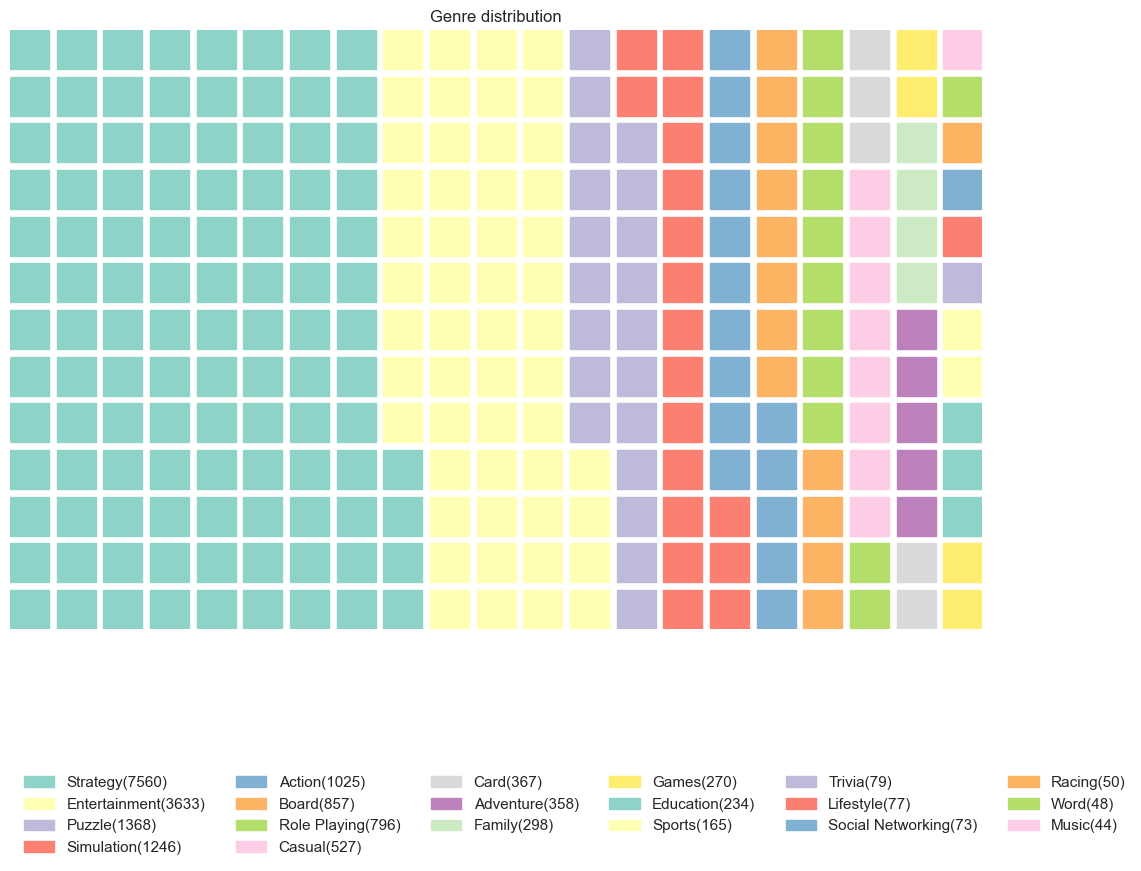

In [41]:
# show the distribution
genre_list = games_df['GenresList']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(genre_list), columns=mlb.classes_, index=genre_list.index)

# assign colour palette
color = sns.color_palette('Set3', n_colors=20).as_hex()

y = res.apply(sum).sort_values(ascending=False)[:20]

fig = plt.figure(
    FigureClass=Waffle, 
    rows=13, 
    columns=21, 
    values=y,
    labels=["{}({})".format(a, b) for a, b in zip(y.index, y) ],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(y)//3,  'framealpha': 0},
    font_size=20, 
    figsize=(12, 12),  
    icon_legend=True,
    colors=color
    )

plt.title('Genre distribution')

plt.show()

We can see that all apps include 'strategy' and the top 3 genres are 'entertainment', 'puzzle', and 'simulation'.

In [42]:
# Create dummy columns from the 'Genres' column
Genres_dummies = games_df['Genres'].str.get_dummies(sep=', ').add_prefix('Genres_')

# Concatenate the dummies to the original DataFrame
games_df = pd.concat([games_df.reset_index(drop=True), Genres_dummies.reset_index(drop=True)], axis=1)

# Get the top 10 most common genres
top_genres = Genres_dummies.sum().sort_values(ascending=False).head(10).index.tolist()

# Compute mean price for apps that have and don't have each genre
genre_price_means = []

for genre_col in top_genres:
    grouped = games_df.groupby(genre_col)['Price'].mean()
    genre_price_means.append({
        'Genre': genre_col.replace('Genres_', ''),
        'Has Genre': grouped.get(1, 0),
        'No Genre': grouped.get(0, 0)
    })

# Convert the result to a DataFrame
genre_price_df = pd.DataFrame(genre_price_means)
genre_price_df = genre_price_df[~genre_price_df['Genre'].isin(['Games', 'Strategy'])]
print(genre_price_df)

           Genre  Has Genre  No Genre
2  Entertainment   0.507136  0.633618
3         Puzzle   0.325212  0.625666
4     Simulation   0.812705  0.523675
5         Action   0.375249  0.602052
6          Board   1.268996  0.482117
7   Role Playing   0.677952  0.558757
8         Casual   0.149184  0.602931
9           Card   0.687684  0.565368


The mean prices for the top 6 genres are found out as follows:

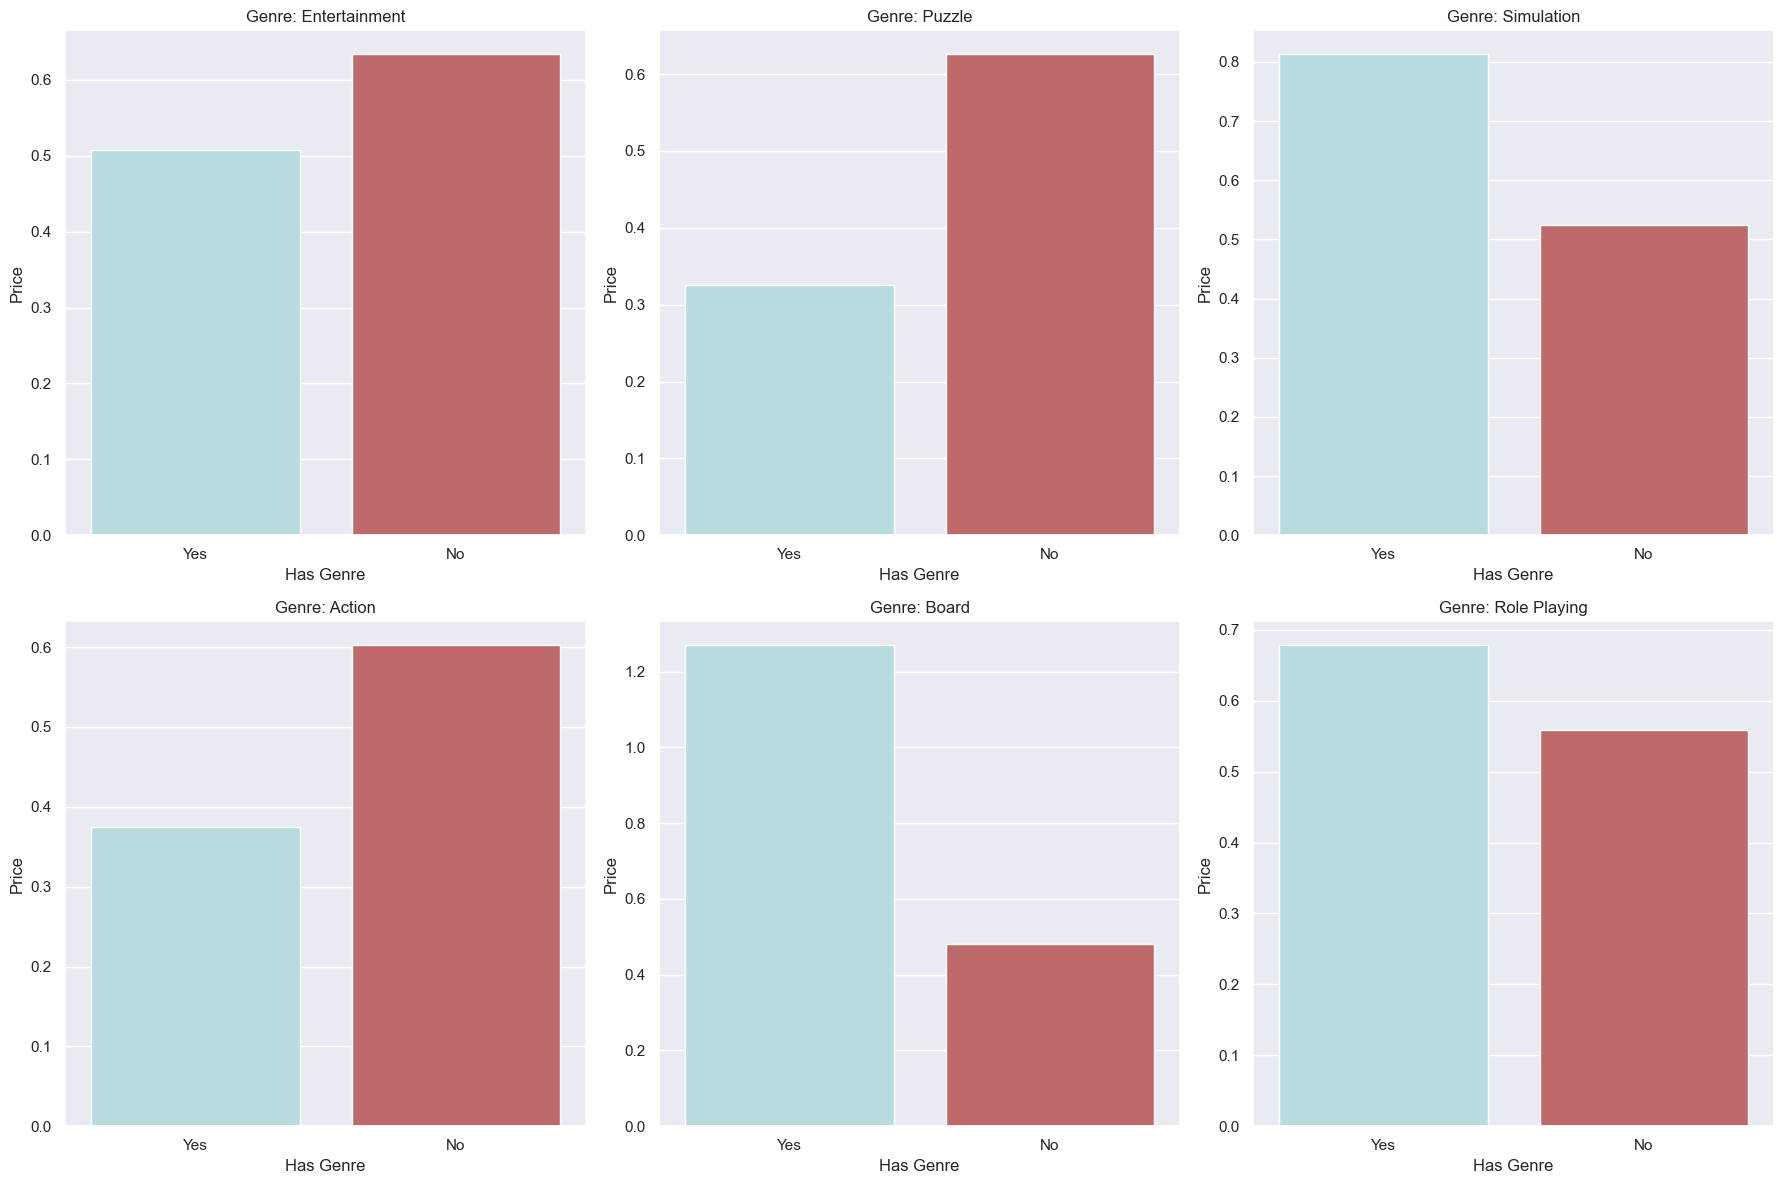

In [43]:
# Select top 6 by 'Has Genre' count 
top6_genres = genre_price_df.reset_index().head(6) 

# Setup plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
palette = ['powderblue', 'indianred']

# Plot each genre dynamically
for i, row in top6_genres.iterrows():
    genre = row['Genre']
    data = pd.DataFrame({
        'Has Genre': ['Yes', 'No'],
        'Price': [row['Has Genre'], row['No Genre']]
    })
    sns.barplot(x='Has Genre', y='Price', data=data, ax=axes[i], palette=palette)
    axes[i].set_title(f"Genre: {genre}")

plt.tight_layout()
plt.show()

In [44]:
# Reuse top_genres and genre filtering from earlier
filtered_top_genres = [g for g in top_genres if g not in ['Genres_Games', 'Genres_Strategy']]

# Compute mean IAPMean for apps that have and don’t have each genre
genre_iap_means = []

for genre_col in filtered_top_genres:
    grouped = games_df.groupby(genre_col)['IAPMean'].mean()
    genre_iap_means.append({
        'Genre': genre_col.replace('Genres_', ''),
        'Has Genre': grouped.get(1, 0),
        'No Genre': grouped.get(0, 0)
    })

# Convert to DataFrame
genre_iap_df = pd.DataFrame(genre_iap_means)
print(genre_iap_df)

           Genre  Has Genre  No Genre
0  Entertainment   5.080899  5.852475
1         Puzzle   2.283333  6.176787
2     Simulation   7.123319  5.146601
3         Action   7.000903  5.232637
4          Board   2.148755  5.897219
5   Role Playing  12.610138  4.632487
6         Casual   3.222171  5.640938
7           Card   5.247386  5.483827


It is found out that among the top6 genres, apps with 'simulation' and 'board' are more expensive, especially for apps with simulation.

### Size

In [45]:
games_df["Size"].describe()

count    7.561000e+03
mean     1.514679e+08
std      2.550380e+08
min      2.158400e+05
25%      3.061862e+07
50%      7.964672e+07
75%      1.776138e+08
max      4.005591e+09
Name: Size, dtype: float64

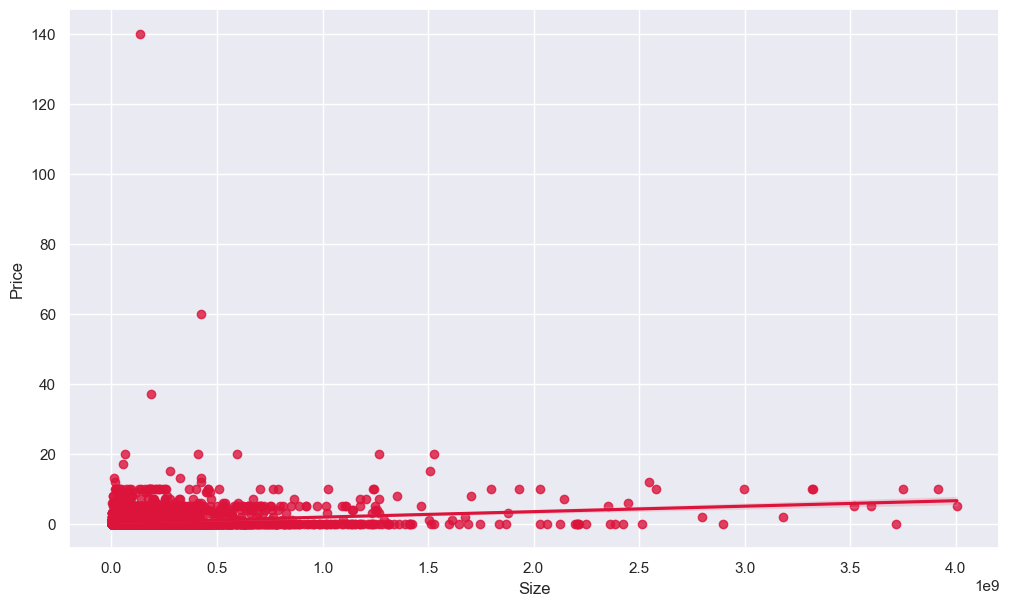

In [46]:
ax = sns.regplot(x='Size',y='Price',data = games_df, color = 'crimson')
ax.set_xlabel('Size')
ax.set_ylabel('Price')
plt.show()

As shown on the scatter plot, there is a slightly positive relationship between price and size, a larger sized game tend to charge a higher price.

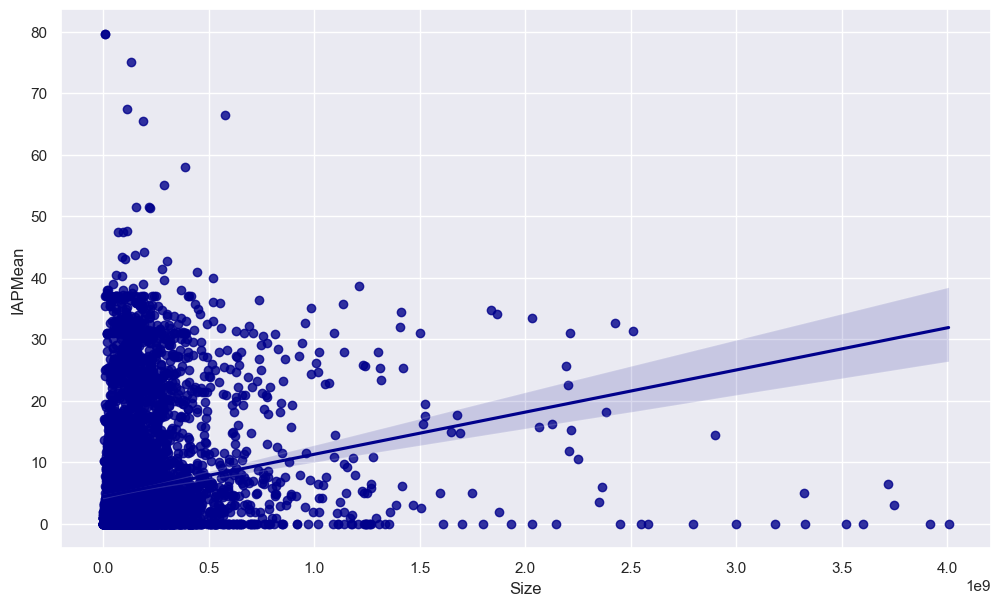

In [47]:
ax = sns.regplot(x='Size',y='IAPMean',data = games_df, color = 'darkblue')
ax.set_xlabel('Size')
ax.set_ylabel('IAPMean')
plt.show()

### Inapp Purchase

We try to find out whether inapp purchase will affect the price and vice versa. 


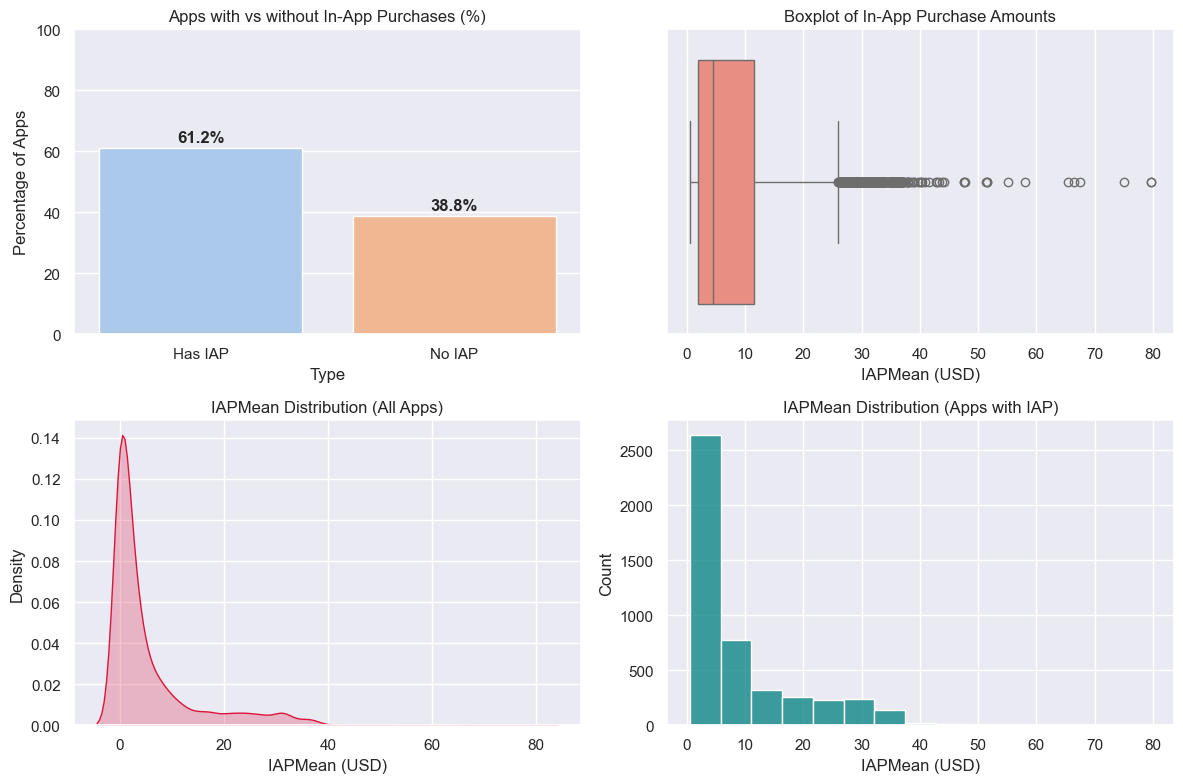

In [48]:
# Create filtered datasets
iap_df = games_df.copy()
iap_df['HasIAP'] = iap_df['IAPMean'] > 0
iap_positive = iap_df[iap_df['IAPMean'] > 0]
all_iap = iap_df['IAPMean']
positive_iap = iap_positive['IAPMean']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Compute percentage of apps with/without IAP
iap_group = iap_df['HasIAP'].value_counts(normalize=True).rename({True: 'Has IAP', False: 'No IAP'}) * 100
iap_percent_df = iap_group.reset_index()
iap_percent_df.columns = ['Type', 'Percentage']

# Plot 1: Bar chart of Has IAP vs No IAP
sns.barplot(x='Type', y='Percentage', data=iap_percent_df, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title('Apps with vs without In-App Purchases (%)')
axes[0, 0].set_ylabel('Percentage of Apps')
axes[0, 0].set_ylim(0, 100)

# Add labels on top of bars
for i, row in iap_percent_df.iterrows():
    axes[0, 0].text(i, row['Percentage'] + 1, f"{row['Percentage']:.1f}%", ha='center', va='bottom', fontweight='bold')

# Plot 2: Boxplot of IAPMean for apps with IAP
sns.boxplot(x=positive_iap, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of In-App Purchase Amounts')
axes[0, 1].set_xlabel('IAPMean (USD)')

# Plot 3: KDE of All IAPMean values
sns.kdeplot(all_iap, ax=axes[1, 0], color='crimson', fill=True)
axes[1, 0].set_title('IAPMean Distribution (All Apps)')
axes[1, 0].set_xlabel('IAPMean (USD)')

# Plot 4: Histogram of Positive IAPMean
sns.histplot(positive_iap, ax=axes[1, 1], color='teal', bins=15, kde=False)
axes[1, 1].set_title('IAPMean Distribution (Apps with IAP)')
axes[1, 1].set_xlabel('IAPMean (USD)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()



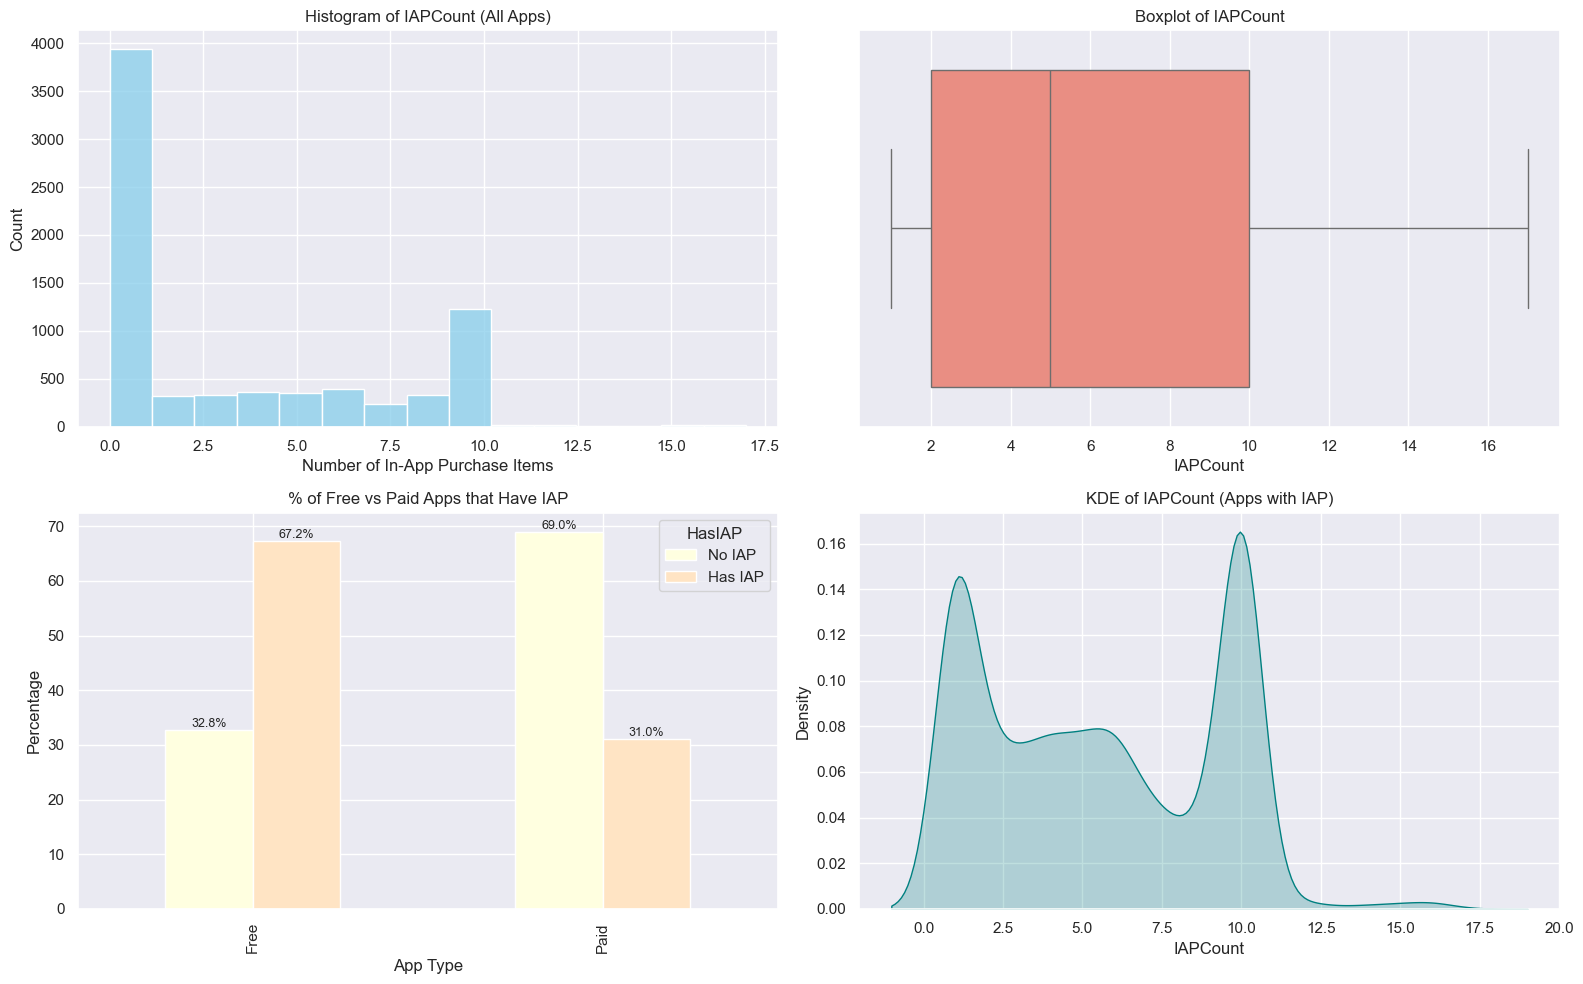

In [49]:
# Copy and prepare data
iap_df = games_df.copy()
iap_df['HasIAP'] = iap_df['IAPCount'] > 0
iap_df['IsFree'] = iap_df['Price'] == 0
iap_positive = iap_df[iap_df['IAPCount'] > 0]
iap_zero = iap_df[iap_df['IAPCount'] == 0]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Plot 1: Histogram of IAPCount ---
sns.histplot(iap_df['IAPCount'], ax=axes[0, 0], bins=15, color='skyblue', kde=False)
axes[0, 0].set_title('Histogram of IAPCount (All Apps)')
axes[0, 0].set_xlabel('Number of In-App Purchase Items')
axes[0, 0].set_ylabel('Count')

# --- Plot 2: Boxplot of IAPCount > 0 ---
sns.boxplot(x=iap_positive['IAPCount'], ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Boxplot of IAPCount')
axes[0, 1].set_xlabel('IAPCount')

# --- Plot 3: % of Free vs Paid apps that have IAP ---
# Create a crosstab of Price Type vs HasIAP
price_type = iap_df['IsFree'].map({True: 'Free', False: 'Paid'})
iap_by_price = pd.crosstab(price_type, iap_df['HasIAP'], normalize='index') * 100
iap_by_price = iap_by_price.rename(columns={True: 'Has IAP', False: 'No IAP'}).reset_index()

# Plot grouped bar chart
iap_by_price.plot(kind='bar', x='IsFree', stacked=False, ax=axes[1, 0], color=['lightyellow', 'bisque'])
axes[1, 0].set_title('% of Free vs Paid Apps that Have IAP')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_xlabel('App Type')

# Add percentage labels
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9)

# --- Plot 4: KDE of IAPCount > 0 ---
sns.kdeplot(iap_positive['IAPCount'], ax=axes[1, 1], fill=True, color='teal')
axes[1, 1].set_title('KDE of IAPCount (Apps with IAP)')
axes[1, 1].set_xlabel('IAPCount')

plt.tight_layout()
plt.show()



### Correlation Analysis

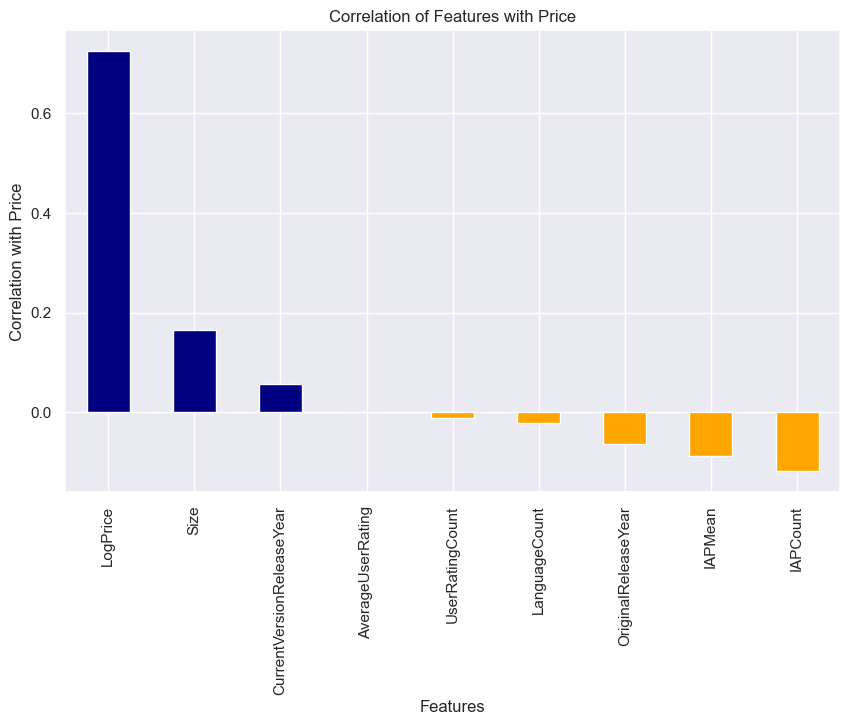

In [50]:
numeric_df = games_df.select_dtypes(include='number')
correlation_with_price = numeric_df.corr()['Price'].drop('Price').sort_values(ascending=False)
correlation_with_price = correlation_with_price[~correlation_with_price.index.str.startswith('Genres_')]

# Define custom colors for the bars
colors = ['navy' if val > 0 else 'orange' for val in correlation_with_price]

# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
correlation_with_price.plot(kind='bar', color=colors)
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.title('Correlation of Features with Price')
plt.show()


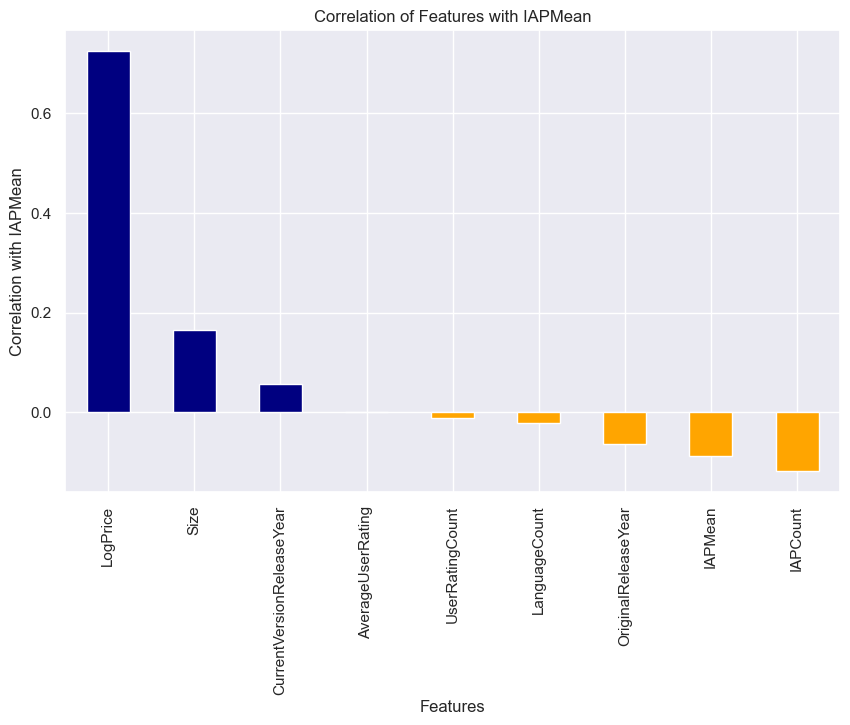

In [51]:
numeric_df = games_df.select_dtypes(include='number')
correlation_with_IAPMean = numeric_df.corr()['Price'].drop('Price').sort_values(ascending=False)
correlation_with_IAPMean = correlation_with_IAPMean[~correlation_with_IAPMean.index.str.startswith('Genres_')]

# Define custom colors for the bars
colors = ['navy' if val > 0 else 'orange' for val in correlation_with_price]

# Create a bar chart with custom colors
plt.figure(figsize=(10, 6))
correlation_with_IAPMean.plot(kind='bar', color=colors)
plt.xlabel('Features')
plt.ylabel('Correlation with IAPMean')
plt.title('Correlation of Features with IAPMean')
plt.show()

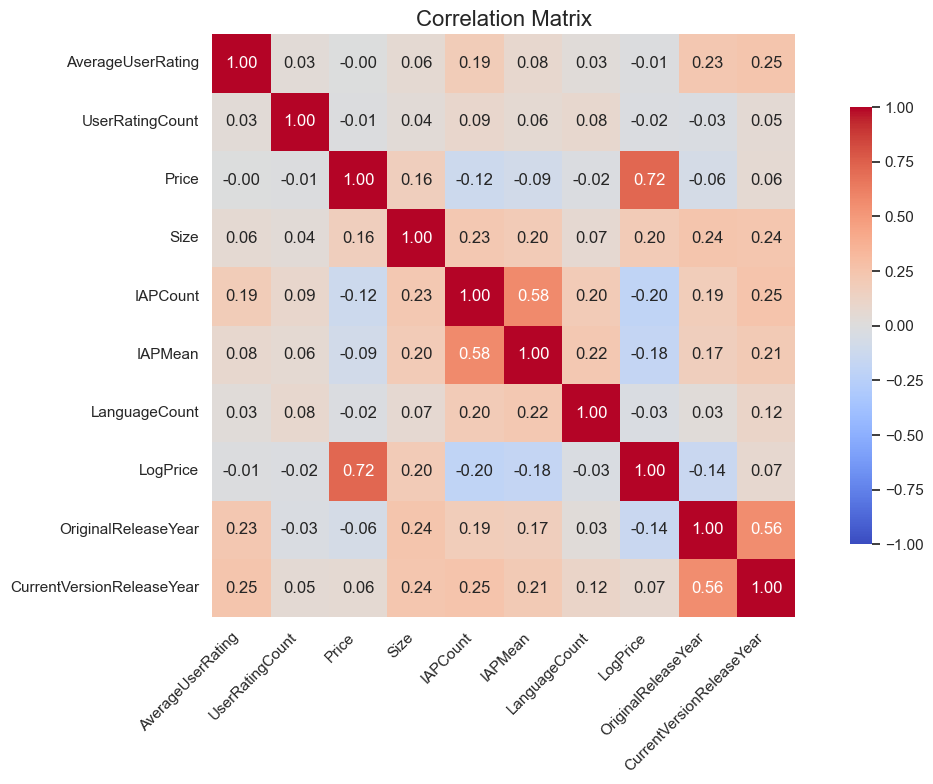

In [52]:
# Exclude dummy Genre columns
filtered_df = numeric_df.loc[:, ~numeric_df.columns.str.startswith('Genres_')]

# Compute correlation matrix
corr_matrix = filtered_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    vmin=-1, vmax=1, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': 0.75}
)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Preparation

To prepare the dataset for machine learning, we proposed two methods: one for **tree-based models** and one for **linear/non-tree models**. For both methods:
- Dropped `Languages` and replaced with `LanguageCount`
- Replaced `Developer` with column `DeveloperGameCount` indicating the number of games the developer published
- One-hot encoded `GenresList` with `Genres_XXX` columns (already applied)
- Replaced `OriginalReleaseDate` and `CurrentVersionReleaseDate` with only the year and convert to `AppAge`
- Label encoded `AgeRating`
- Log-transform `Size`, `UserRatingCount`, `IAPMean`, `Price`
- Dropped `IAPCount` as it leaked information about `IAPMean`

Tree-based Models:
- Label encoded `PrimaryGenre`

Linear Models:
- One-hot encoded `PrimaryGenre`
- Applied StandardScaler and Principal Component Analysis (PCA) for feature normalization and dimensionality reduction

In [53]:
games_df.columns

Index(['Subtitle', 'AverageUserRating', 'UserRatingCount', 'Price',
       'Developer', 'AgeRating', 'Languages', 'Size', 'PrimaryGenre', 'Genres',
       'OriginalReleaseDate', 'CurrentVersionReleaseDate', 'IAPCount',
       'IAPMean', 'LanguageCount', 'LogPrice', 'Lang_Bin',
       'OriginalReleaseYear', 'CurrentVersionReleaseYear', 'GenresList',
       'Genres_Action', 'Genres_Adventure', 'Genres_Board', 'Genres_Books',
       'Genres_Business', 'Genres_Card', 'Genres_Casino', 'Genres_Casual',
       'Genres_Education', 'Genres_Emoji & Expressions',
       'Genres_Entertainment', 'Genres_Family', 'Genres_Finance',
       'Genres_Food & Drink', 'Genres_Games', 'Genres_Gaming',
       'Genres_Health & Fitness', 'Genres_Kids & Family', 'Genres_Lifestyle',
       'Genres_Magazines & Newspapers', 'Genres_Medical', 'Genres_Music',
       'Genres_Navigation', 'Genres_News', 'Genres_Photo & Video',
       'Genres_Productivity', 'Genres_Puzzle', 'Genres_Racing',
       'Genres_Reference', 'G

In [54]:
# Drop Languages, OriginalReleaseDate, CurrentVersionReleaseDate, GenresList columns to reduce dimensionality
games_df = games_df.drop(columns=[
    'Languages', 
    'OriginalReleaseDate', 
    'CurrentVersionReleaseDate', 
    'GenresList',
    'Lang_Bin',
    'Genres'
])

In [55]:
# Count games per developer
dev_counts = games_df['Developer'].value_counts()

# Map the count to a new column
games_df['DeveloperGameCount'] = games_df['Developer'].map(dev_counts)

# Drop original Developer column
games_df = games_df.drop(columns=['Developer'])

In [56]:
# Subtitle: not_empty(1) NaN(0)
games_df['Subtitle'] = games_df['Subtitle'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [57]:
# Create AppAge column
current_year = datetime.now().year
games_df['AppAge'] = current_year - games_df['OriginalReleaseYear']
games_df['VersionAge'] = current_year - games_df['CurrentVersionReleaseYear']

# Delete columns
games_df = games_df.drop(columns=['OriginalReleaseYear', 'CurrentVersionReleaseYear'])

In [58]:
# Initialize encoders for AgeRating 
le_age = LabelEncoder()

# Apply label encoding
games_df['AgeRating'] = le_age.fit_transform(games_df['AgeRating'])

In [59]:
# Log transform
games_df['LogSize'] = np.log1p(games_df['Size'])
games_df['LogUserRatingCount'] = np.log1p(games_df['UserRatingCount'])
games_df['LogPrice'] = np.log1p(games_df['Price'])
games_df['LogIAPMean'] = np.log1p(games_df['IAPMean'])

# Delete columns
games_df = games_df.drop(columns=['Size', 'UserRatingCount', 'Price', 'IAPMean', 'IAPCount'])

In [60]:
# Separate two datasets: one for tree-based models and one for lienar models
tree_games_df = games_df.copy()
linear_games_df = games_df.copy()

In [61]:
# Initialize encoders for PrimaryGenre 
le_primarygenre = LabelEncoder()

# Apply label encoding
tree_games_df['PrimaryGenre'] = le_primarygenre.fit_transform(tree_games_df['PrimaryGenre'])

In [62]:
tree_games_df.head(5)

,Subtitle,AverageUserRating,AgeRating,PrimaryGenre,LanguageCount,LogPrice,Genres_Action,Genres_Adventure,Genres_Board,Genres_Books,...,Genres_Trivia,Genres_Utilities,Genres_Weather,Genres_Word,DeveloperGameCount,AppAge,VersionAge,LogSize,LogUserRatingCount,LogIAPMean
0,0,4.0,2,6,17,1.383791,0,0,0,0,...,0,0,0,0,9,17,8,16.578905,8.175829,0.0
1,0,3.5,2,6,1,1.095273,0,0,1,0,...,0,0,0,0,1,17,7,16.327462,5.652489,0.0
2,0,3.0,2,6,1,0.000000,0,0,1,0,...,0,0,0,0,2,17,8,13.422197,9.033245,0.0
3,0,3.5,2,6,17,0.000000,0,0,0,0,...,0,0,0,0,9,17,8,16.885985,12.156856,0.0
4,0,3.5,2,6,15,1.383791,0,0,1,0,...,0,0,0,0,1,17,7,17.361934,3.367296,0.0


In [63]:
# Apply one hot encoding for PrimaryGenre
one_hot_genre = pd.get_dummies(linear_games_df['PrimaryGenre'], prefix='PrimaryGenre')

# Drop original PrimaryGenre and concatenate encoded version
linear_games_df = linear_games_df.drop(columns=['PrimaryGenre'])
linear_games_df = pd.concat([linear_games_df, one_hot_genre], axis=1)

In [64]:
linear_games_df.columns

Index(['Subtitle', 'AverageUserRating', 'AgeRating', 'LanguageCount',
       'LogPrice', 'Genres_Action', 'Genres_Adventure', 'Genres_Board',
       'Genres_Books', 'Genres_Business', 'Genres_Card', 'Genres_Casino',
       'Genres_Casual', 'Genres_Education', 'Genres_Emoji & Expressions',
       'Genres_Entertainment', 'Genres_Family', 'Genres_Finance',
       'Genres_Food & Drink', 'Genres_Games', 'Genres_Gaming',
       'Genres_Health & Fitness', 'Genres_Kids & Family', 'Genres_Lifestyle',
       'Genres_Magazines & Newspapers', 'Genres_Medical', 'Genres_Music',
       'Genres_Navigation', 'Genres_News', 'Genres_Photo & Video',
       'Genres_Productivity', 'Genres_Puzzle', 'Genres_Racing',
       'Genres_Reference', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social Networking', 'Genres_Sports',
       'Genres_Stickers', 'Genres_Strategy', 'Genres_Travel', 'Genres_Trivia',
       'Genres_Utilities', 'Genres_Weather', 'Genres_Word',
       'Developer

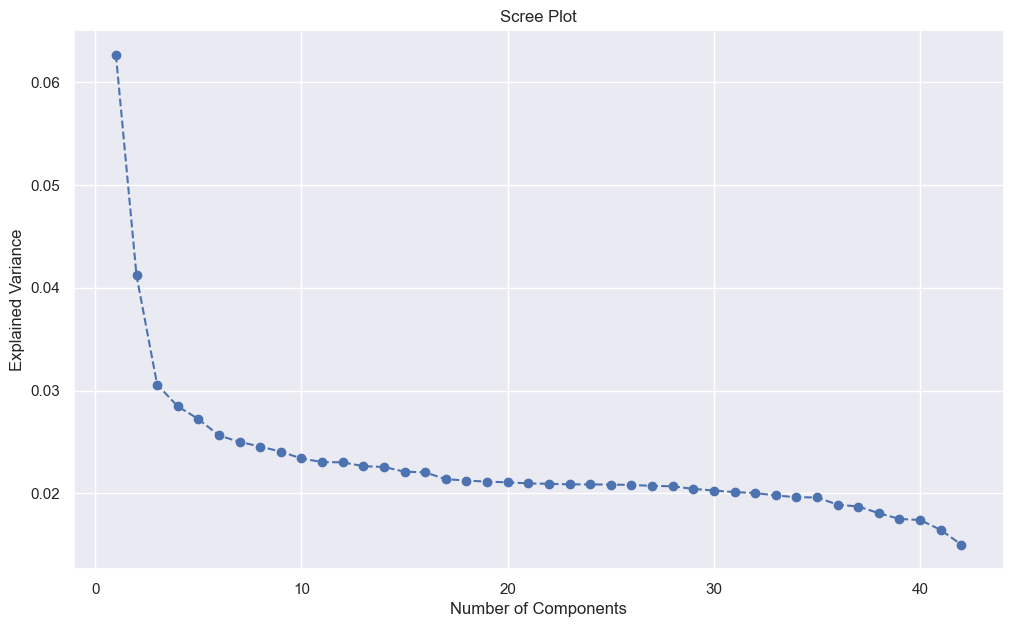

In [65]:

# Select only numeric columns for scaling and PCA
X = linear_games_df.drop(columns=['LogIAPMean']) 
X = X.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# See how much variance each component explains
explained_variance = pca.explained_variance_ratio_

# Plot the scree plot
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [66]:
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,-0.034279,-0.266097,-0.038022,0.360108,0.494440,1.584950,1.388949,-0.918049,0.760984,-0.136769,...,-0.398221,0.719367,0.146731,-0.677553,0.000845,0.338315,1.366091,2.375889,0.399490,0.200306
1,0.039154,-1.322938,-1.449393,-2.014182,-0.284527,1.385101,0.568153,0.266275,-0.311823,-0.003192,...,-0.631377,0.050431,0.758782,0.456938,-0.216320,-0.044350,0.525237,0.238627,0.330108,-0.855009
2,0.137428,-2.204269,-0.903622,-1.351767,-0.607193,1.185839,0.317503,0.729683,0.088469,-0.120790,...,-0.844511,-0.018757,1.066791,0.087793,0.031745,-0.399171,0.360615,-0.699226,2.030492,-1.462275
3,-0.061140,0.208236,0.580175,1.152952,0.212707,1.239866,1.028792,-0.498557,1.028410,-0.382541,...,-0.399068,0.518805,0.316216,-0.936162,0.437363,0.036460,0.998324,1.152169,1.610217,-0.037263
4,-0.010063,-1.239798,-3.177459,-1.914437,1.001179,3.191936,1.036580,0.482628,-1.125139,-1.113175,...,0.574480,0.145729,0.205622,-0.177234,1.946274,-0.257607,0.845017,0.474347,0.622704,0.568051


# Modelling - Regressors

We begin by setting `LogIAPMean` as the target for models. We will test different ML techniques for model comparisons.

Tree-based Models:
- Random Forest Regressor
- XGB Regressor
- AdaBoost Regressor
  
Linear Models:
- Linear Regression
- Support Vector Regressor (SVR)
- KNN Regressor

In [67]:
features = tree_games_df.columns.values

X = tree_games_df.drop(columns='LogIAPMean')
y = tree_games_df['LogIAPMean'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

In [68]:

# Define function to print model results
def print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor"):

    if modelType == "regressor":
        # Regression metrics
        print("Train R² Score:", r2_score(y_train, train_preds))
        print("Test R² Score:", r2_score(y_test, test_preds))
        
        print("Train MAE:", mean_absolute_error(y_train, train_preds))
        print("Test MAE:", mean_absolute_error(y_test, test_preds))
        
        print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
        print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))

    elif modelType == "classifier":
        # Classification metrics
        print("Train Accuracy:", accuracy_score(y_train, train_preds))
        print("Test Accuracy:", accuracy_score(y_test, test_preds))
        
        print("\nTrain Classification Report:\n", classification_report(y_train, train_preds, digits=3))
        print("\nTest Classification Report:\n", classification_report(y_test, test_preds, digits=3))

        # Compute confusion matrix
        cm = confusion_matrix(y_test, test_preds)
        
        # Optional: define class labels
        labels = ['Free', 'Low', 'High'] 
        
        # Plot
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

    else:
        print("Error: modelType must be either 'regressor' or 'classifier'")


## Tree-based Models

### RandomForestRegressor

In [69]:
# Initialize model
rfr = RandomForestRegressor(random_state=1)

# Fit the model
rfr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = rfr.predict(X_train)
test_preds = rfr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds , modelType="regressor")

Train R² Score: 0.925502245364689
Test R² Score: 0.4698835892379042
Train MAE: 0.2406323143069425
Test MAE: 0.6428474474935454
Train RMSE: 0.31393627722752804
Test RMSE: 0.8382757668719593


The model demonstrated a strong fit on the training data (R² = 0.93, MAE = 0.24, RMSE = 0.31), but has poor perforamce on the test set (R² = 0.47, MAE = 0.64, RMSE = 0.84)., suggesting overfitting and weak generalization. Further tuning is required to improve prediction error on unseen data.

In [70]:

# Define hyperparameter distributions for RFR
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Randomized search setup
rfr_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=1),
    param_distributions=param_dist,
    n_iter=50,           
    cv=5,
    n_jobs=-1,
    random_state=1,
    scoring='neg_mean_absolute_error' 
)

# Fit on training data
rfr_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", rfr_search.best_params_)


Best parameters found: {'max_depth': 38, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 196}


In [71]:
# Make predictions
train_preds = rfr_search.predict(X_train)
test_preds = rfr_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds)

Train R² Score: 0.8606629756635298
Test R² Score: 0.47812136097106483
Train MAE: 0.339438631120164
Test MAE: 0.656701925746047
Train RMSE: 0.4293418052913769
Test RMSE: 0.8317370501356376


### XGBRegressor

In [72]:
# Initialize model
xgb = XGBRegressor(random_state=1, n_jobs=-1, verbosity=0)

# Fit the model
xgb.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.8257668727177795
Test R² Score: 0.42909024094151116
Train MAE: 0.35367182312266254
Test MAE: 0.6648292339770174
Train RMSE: 0.4801039489941748
Test RMSE: 0.8699314274918288


In [73]:

# Define hyperparameter distributions for XGB
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

# Randomized search setup
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=1, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=50,           
    cv=5,
    n_jobs=-1,
    random_state=1,
    scoring='neg_mean_absolute_error'
)

# Fit on training data
xgb_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", xgb_search.best_params_)


Best parameters found: {'colsample_bytree': np.float64(0.9318413437576735), 'gamma': np.float64(0.13652498710837369), 'learning_rate': np.float64(0.02777296039046904), 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 487, 'subsample': np.float64(0.8686616389688537)}


In [74]:
# Make predictions
train_preds = xgb_search.predict(X_train)
test_preds = xgb_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.9030482982934481
Test R² Score: 0.4664553430137828
Train MAE: 0.2670430594211259
Test MAE: 0.6385574207677254
Train RMSE: 0.35813571280669454
Test RMSE: 0.8409819502858737


### AdaBoostRegressor

In [75]:

# Initialize model
estimator = DecisionTreeRegressor(max_depth=5)
ada = AdaBoostRegressor(estimator=estimator, n_estimators=75, learning_rate=0.1, random_state=1)

# Fit the model
ada.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = ada.predict(X_train)
test_preds = ada.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.4454914471994593
Test R² Score: 0.4091707852119054
Train MAE: 0.7098160674993701
Test MAE: 0.7213089780987781
Train RMSE: 0.8564934318596462
Test RMSE: 0.8849775792978214


In [76]:

# Define parameter distribution
param_dist_ada = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 10)  # Tuning the base decision tree
}

# Setup AdaBoost with DecisionTreeRegressor as base estimator
base_estimator = DecisionTreeRegressor(random_state=1)
ada = AdaBoostRegressor(estimator=base_estimator, random_state=1)

# RandomizedSearchCV
ada_search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist_ada,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=1,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
ada_search.fit(X_train, y_train.values.ravel())

# Output best parameters
print("Best parameters found:", ada_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'estimator__max_depth': 9, 'learning_rate': np.float64(0.10834683383305009), 'n_estimators': 181}


In [77]:
# Make predictions
train_preds = ada_search.predict(X_train)
test_preds = ada_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.6318065287865766
Test R² Score: 0.44329108010667917
Train MAE: 0.5694879469635338
Test MAE: 0.6895341062623973
Train RMSE: 0.6979237123410155
Test RMSE: 0.8590439372726982


## Linear Models

In [78]:
# Select target variable
y = linear_games_df['LogIAPMean']
# X = linear_games_df.drop(columns='LogIAPMean')
# pca_df

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1
)

### Linear Regression

In [79]:
# Initialize model
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.3819454827799661
Test R² Score: 0.37181253889119015
Train MAE: 0.7275647719297662
Test MAE: 0.7329803210023454
Train RMSE: 0.9042391466942145
Test RMSE: 0.9125274110482989


### Support Vector Regressor

In [80]:

# Initialize model
svr = SVR(kernel='rbf') 

# Fit the model
svr.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = svr.predict(X_train)
test_preds = svr.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.3695960161186779
Test R² Score: 0.3603812381110447
Train MAE: 0.7187689693237244
Test MAE: 0.730197518567668
Train RMSE: 0.9132283535231895
Test RMSE: 0.9207927356742199


In [81]:
# Define hyperparameter distributions
svr_param_dist = {
    'C': uniform(0.1, 10),         
    'epsilon': uniform(0.01, 1.0),  
    'gamma': ['scale', 'auto'],       
}

# Setup RandomizedSearchCV
svr_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=svr_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',  
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit to training data
svr_search.fit(X_train, y_train.values.ravel())
print("Best SVR parameters:", svr_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best SVR parameters: {'C': np.float64(6.218528947223795), 'epsilon': np.float64(0.14949386065204184), 'gamma': 'auto'}


In [82]:
# Make predictions
train_preds = svr_search.predict(X_train)
test_preds = svr_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.6111561016217285
Test R² Score: 0.4477124358470572
Train MAE: 0.5050537801755901
Test MAE: 0.6432892002063736
Train RMSE: 0.7172285298472885
Test RMSE: 0.8556258942325963


### KNN Regressor

In [83]:
# Initialize model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.5660913338828557
Test R² Score: 0.3319358445195605
Train MAE: 0.5717909468805539
Test MAE: 0.7218036994238493
Train RMSE: 0.7576507793727921
Test RMSE: 0.9410449587787005


In [84]:

# Define hyperparameter distributions
knn_param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform'],
    'p': [1, 2] 
}

# Setup RandomizedSearchCV
knn_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=knn_param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit to training data
knn_search.fit(X_train, y_train.values.ravel())
print("Best KNN parameters:", knn_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best KNN parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


In [85]:
# Make predictions
train_preds = knn_search.predict(X_train)
test_preds = knn_search.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="regressor")

Train R² Score: 0.5507677200566635
Test R² Score: 0.3846259178950805
Train MAE: 0.5921537373497195
Test MAE: 0.7049409819683033
Train RMSE: 0.7709130366457013
Test RMSE: 0.9031728786432716


### Model Comparisons

xgb: Best parameters found: {'colsample_bytree': np.float64(0.9318413437576735), 'gamma': np.float64(0.13652498710837369), 'learning_rate': np.float64(0.02777296039046904), 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 487, 'subsample': np.float64(0.8686616389688537)}
linear regression

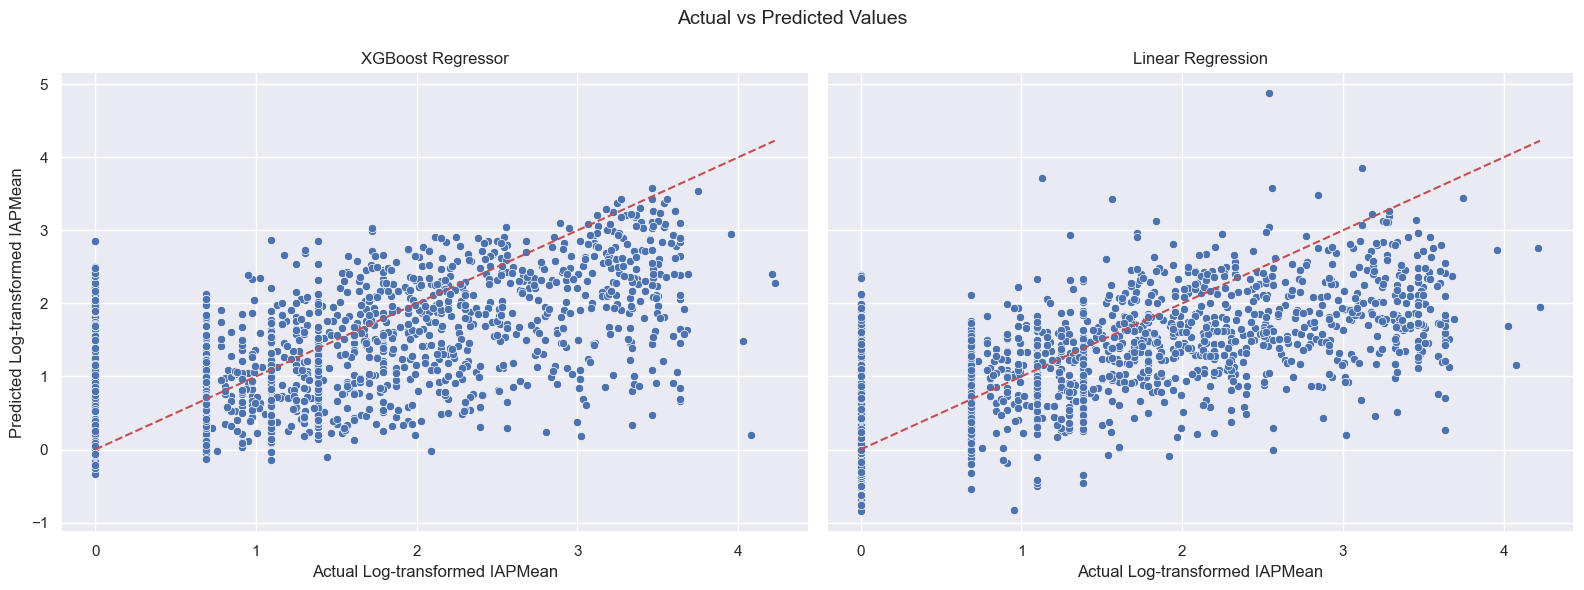

In [86]:
# Make predictions for the two best models
xgb_train_preds = xgb_search.predict(X_train)
xgb_test_preds = xgb_search.predict(X_test)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Regressor
sns.scatterplot(x=y_test, y=xgb_test_preds, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[0].set_xlabel("Actual Log-transformed IAPMean")
axes[0].set_ylabel("Predicted Log-transformed IAPMean")
axes[0].set_title("XGBoost Regressor")

# Linear Regression
sns.scatterplot(x=y_test, y=lr_test_preds, ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[1].set_xlabel("Actual Log-transformed IAPMean")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression")

plt.suptitle("Actual vs Predicted Values", fontsize=14)
plt.tight_layout()
plt.show()



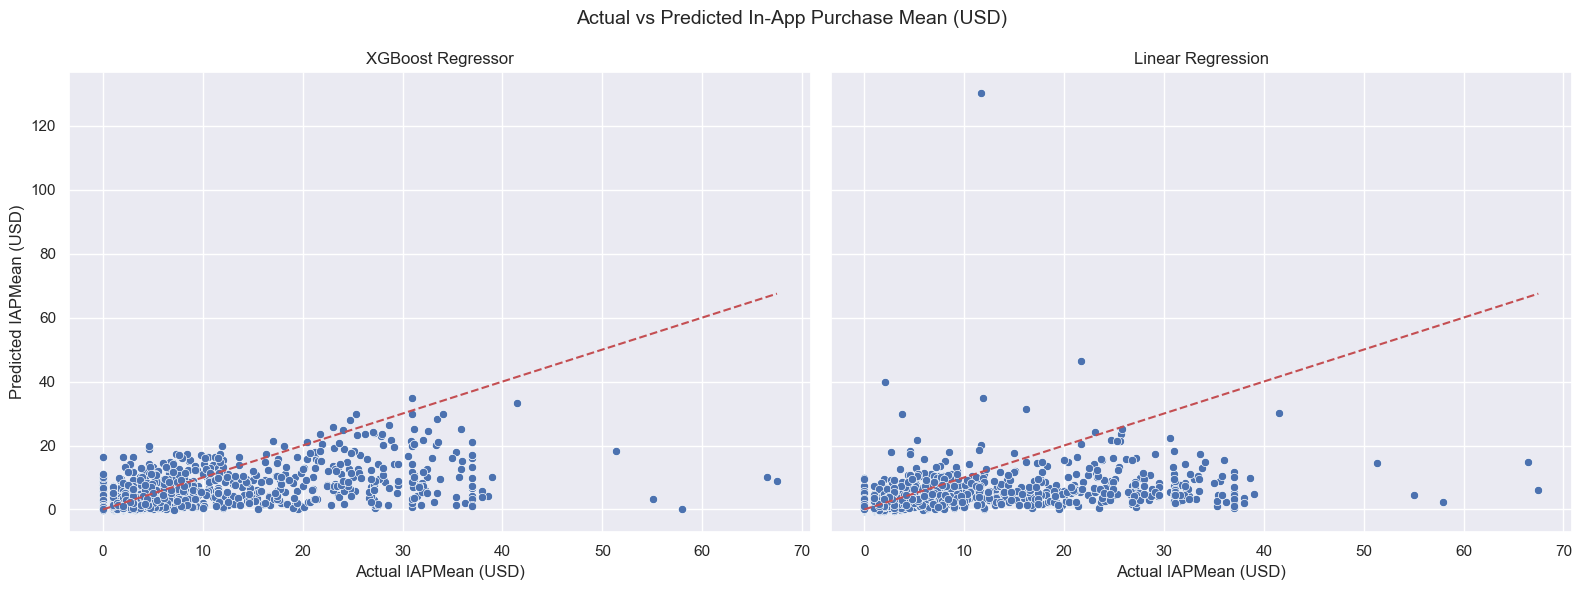

In [87]:

# Inverse-transform predictions 
actual_iap = np.expm1(y_test)             
xgb_preds_iap = np.expm1(xgb_test_preds)
lr_preds_iap = np.expm1(lr_test_preds)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Regressor
sns.scatterplot(x=actual_iap, y=xgb_preds_iap, ax=axes[0])
axes[0].plot([actual_iap.min(), actual_iap.max()], [actual_iap.min(), actual_iap.max()], '--r')
axes[0].set_xlabel("Actual IAPMean (USD)")
axes[0].set_ylabel("Predicted IAPMean (USD)")
axes[0].set_title("XGBoost Regressor")

# Linear Regression
sns.scatterplot(x=actual_iap, y=lr_preds_iap, ax=axes[1])
axes[1].plot([actual_iap.min(), actual_iap.max()], [actual_iap.min(), actual_iap.max()], '--r')
axes[1].set_xlabel("Actual IAPMean (USD)")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression")

plt.suptitle("Actual vs Predicted In-App Purchase Mean (USD)", fontsize=14)
plt.tight_layout()
plt.show()


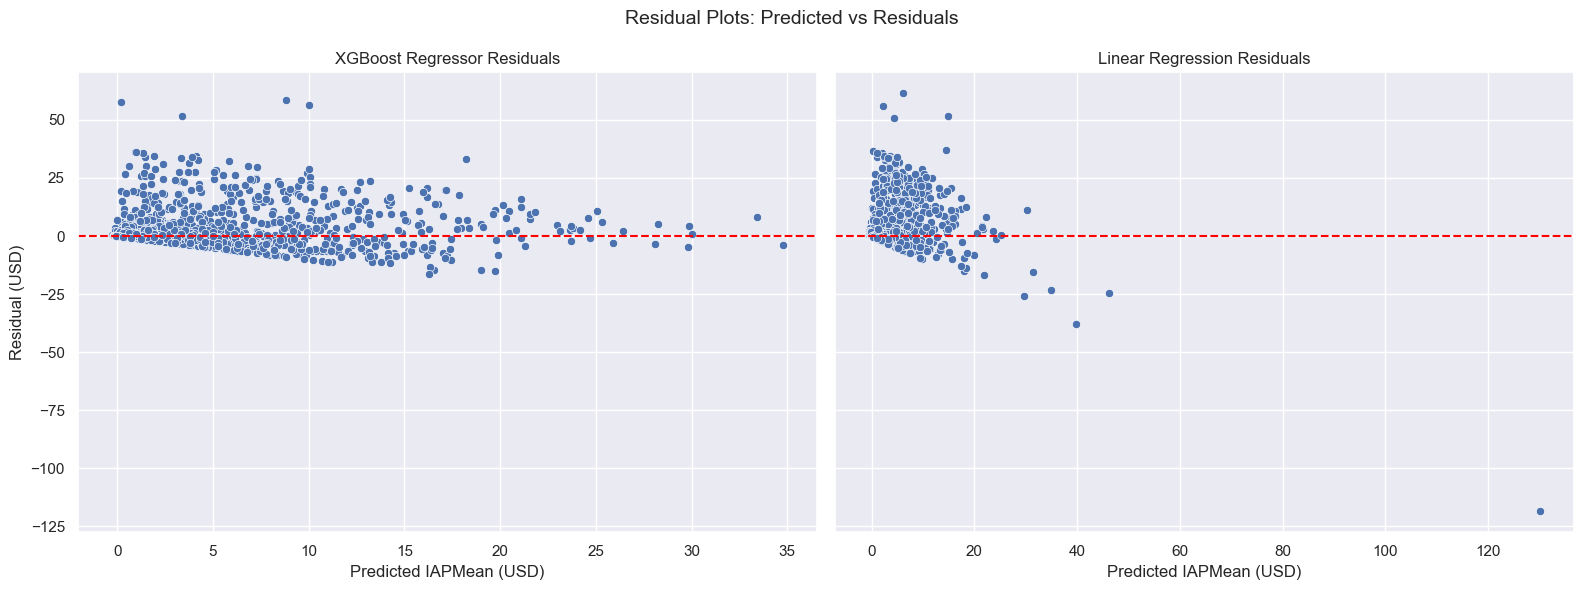

In [88]:
# Calculate residuals
xgb_residuals = actual_iap - xgb_preds_iap
lr_residuals = actual_iap - lr_preds_iap

# Plot residuals side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# XGBoost Residual Plot
sns.scatterplot(x=xgb_preds_iap, y=xgb_residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted IAPMean (USD)")
axes[0].set_ylabel("Residual (USD)")
axes[0].set_title("XGBoost Regressor Residuals")

# Linear Regression Residual Plot
sns.scatterplot(x=lr_preds_iap, y=lr_residuals, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted IAPMean (USD)")
axes[1].set_ylabel("") 
axes[1].set_title("Linear Regression Residuals")

plt.suptitle("Residual Plots: Predicted vs Residuals", fontsize=14)
plt.tight_layout()
plt.show()


### Modelling - Classifiers

We aim to categorize IAPMean into three distinct classes:

- **Free**: Apps with no in–app purchases (`IAPMean = 0`)
- **Low**: Paid apps with in–app purchases up to 5
- **High**: Paid apps with in–app purchases greater than 5

This classification is based on exploratory data analysis (EDA), which revealed that the median of non-free IAPMean is approximately $5. This threshold provides a reasonably balanced class distribution. We will also use classifier models for this task.


Tree-Based Models:
- Random Forest Classifier
- XGBoost Classifier
- AdaBoost Classifier


Linear & Distance-Based Models:
- Logistic Regression
- Support Vector Classifier (SVC)
- K-Nearest Neighbors (KNN) Classifier

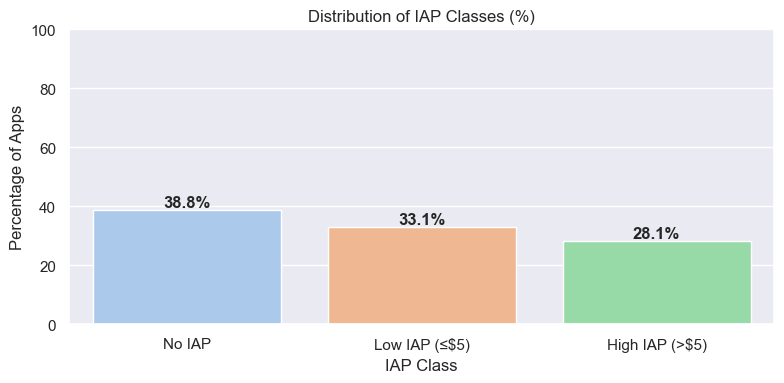

In [89]:
# Undo log-transformed IAPMean
games_df['IAPMean'] = np.expm1(games_df['LogIAPMean'])

# Create 'IAPClass' column
games_df['IAPClass'] = games_df['IAPMean'].apply(lambda x: 0 if x == 0 else None)

# Filter only non-zero IAP
non_zero = games_df[games_df['IAPMean'] > 0]

# Use $5 as threshold
threshold = 5  

# Assign class 1 or 2
games_df.loc[(games_df['IAPMean'] > 0) & (games_df['IAPMean'] <= threshold), 'IAPClass'] = 1
games_df.loc[games_df['IAPMean'] > threshold, 'IAPClass'] = 2

# Drop IAPMean column
games_df = games_df.drop(columns=['LogIAPMean', 'IAPMean'])

# Calculate class distribution
class_counts = games_df['IAPClass'].value_counts(normalize=True).sort_index()
class_labels = ['No IAP', 'Low IAP (≤$5)', 'High IAP (>$5)']
percentages = (class_counts * 100).round(1)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=class_labels, y=percentages.values, palette='pastel')

# Add percentages on top of bars
for i, pct in enumerate(percentages):
    plt.text(i, pct + 1, f'{pct}%', ha='center', fontsize=12, fontweight='bold')

plt.title('Distribution of IAP Classes (%)')
plt.ylabel('Percentage of Apps')
plt.xlabel('IAP Class')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [90]:
games_df.head(5)

,Subtitle,AverageUserRating,AgeRating,PrimaryGenre,LanguageCount,LogPrice,Genres_Action,Genres_Adventure,Genres_Board,Genres_Books,...,Genres_Trivia,Genres_Utilities,Genres_Weather,Genres_Word,DeveloperGameCount,AppAge,VersionAge,LogSize,LogUserRatingCount,IAPClass
0,0,4.0,2,Games,17,1.383791,0,0,0,0,...,0,0,0,0,9,17,8,16.578905,8.175829,0.0
1,0,3.5,2,Games,1,1.095273,0,0,1,0,...,0,0,0,0,1,17,7,16.327462,5.652489,0.0
2,0,3.0,2,Games,1,0.000000,0,0,1,0,...,0,0,0,0,2,17,8,13.422197,9.033245,0.0
3,0,3.5,2,Games,17,0.000000,0,0,0,0,...,0,0,0,0,9,17,8,16.885985,12.156856,0.0
4,0,3.5,2,Games,15,1.383791,0,0,1,0,...,0,0,0,0,1,17,7,17.361934,3.367296,0.0


In [91]:
# Separate two datasets: one for tree-based models and one for lienar models
tree_games_df = games_df.copy()
linear_games_df = games_df.copy()

In [92]:
# Initialize encoders for PrimaryGenre 
le_primarygenre = LabelEncoder()

# Apply label encoding
tree_games_df['PrimaryGenre'] = le_primarygenre.fit_transform(tree_games_df['PrimaryGenre'])

In [93]:
# Apply one hot encoding for PrimaryGenre
one_hot_genre = pd.get_dummies(linear_games_df['PrimaryGenre'], prefix='PrimaryGenre')

# Drop original PrimaryGenre and concatenate encoded version
linear_games_df = linear_games_df.drop(columns=['PrimaryGenre'])
linear_games_df = pd.concat([linear_games_df, one_hot_genre], axis=1)

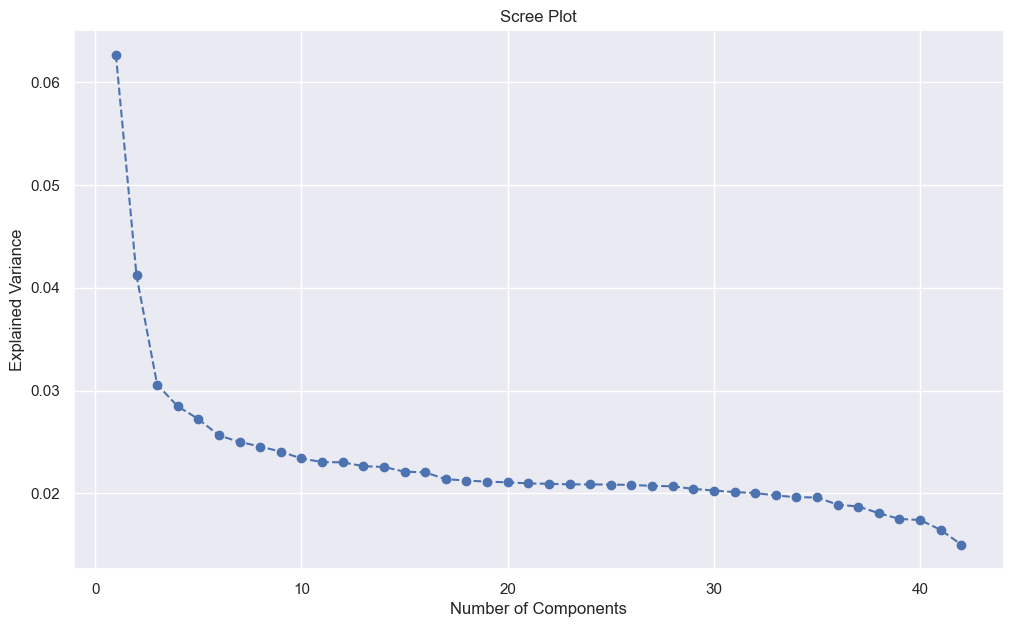

In [94]:

# Select only numeric columns for scaling and PCA
X = linear_games_df.drop(columns=['IAPClass']) 
X = X.select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# See how much variance each component explains
explained_variance = pca.explained_variance_ratio_

# Plot the scree plot
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [95]:
features = tree_games_df.columns.values

X = tree_games_df.drop(columns='IAPClass')
y = tree_games_df['IAPClass'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

### RandomForestClassifier

Train Accuracy: 1.0
Test Accuracy: 0.6282390269698572

Train Classification Report:
               precision    recall  f1-score   support

         0.0      1.000     1.000     1.000      2222
         1.0      1.000     1.000     1.000      1869
         2.0      1.000     1.000     1.000      1579

    accuracy                          1.000      5670
   macro avg      1.000     1.000     1.000      5670
weighted avg      1.000     1.000     1.000      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.628     0.744     0.681       710
         1.0      0.567     0.434     0.492       636
         2.0      0.682     0.705     0.693       545

    accuracy                          0.628      1891
   macro avg      0.626     0.627     0.622      1891
weighted avg      0.623     0.628     0.621      1891



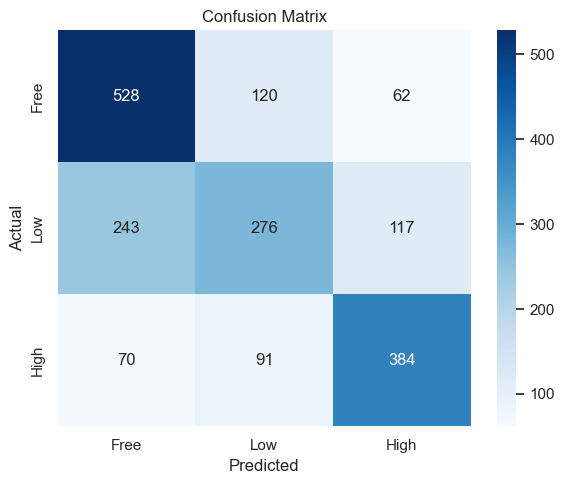

In [96]:
# Initialize model
rfc = RandomForestClassifier(random_state=1)

# Fit the model
rfc.fit(X_train, y_train.values.ravel())

# Make predictions
train_preds = rfc.predict(X_train)
test_preds = rfc.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="classifier")

In [97]:
# Define hyperparameter space
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize model
rfc = RandomForestClassifier(random_state=1)

# Set up random search
rscv = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=20,               
    cv=5,                 
    scoring='accuracy',       
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
rscv.fit(X_train, y_train)

# Best model
best_clf = rscv.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


Train Accuracy: 0.9941798941798942
Test Accuracy: 0.6345848757271285

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.989     1.000     0.995      2222
         1.0      0.995     0.991     0.993      1869
         2.0      1.000     0.990     0.995      1579

    accuracy                          0.994      5670
   macro avg      0.995     0.994     0.994      5670
weighted avg      0.994     0.994     0.994      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.636     0.752     0.689       710
         1.0      0.564     0.448     0.500       636
         2.0      0.697     0.699     0.698       545

    accuracy                          0.635      1891
   macro avg      0.632     0.633     0.629      1891
weighted avg      0.630     0.635     0.628      1891



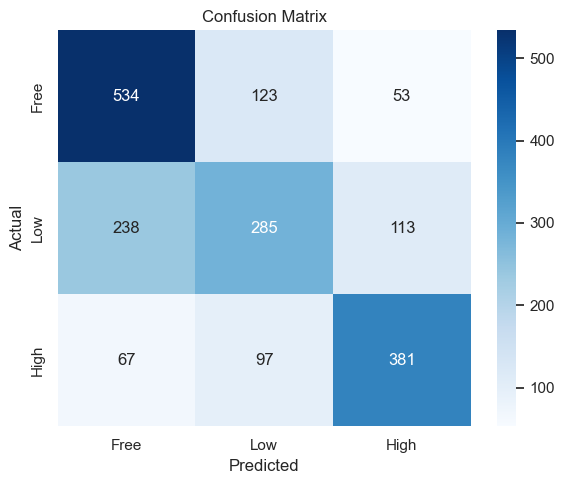

In [98]:
# Make predictions
train_preds = best_clf.predict(X_train)
test_preds = best_clf.predict(X_test)

# Evaluate model performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType="classifier")

### XGBClassifier

Train Accuracy: 0.9135802469135802
Test Accuracy: 0.6076150185087256

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.911     0.930     0.920      2222
         1.0      0.914     0.862     0.887      1869
         2.0      0.917     0.952     0.934      1579

    accuracy                          0.914      5670
   macro avg      0.914     0.915     0.914      5670
weighted avg      0.914     0.914     0.913      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.623     0.696     0.657       710
         1.0      0.524     0.445     0.481       636
         2.0      0.667     0.683     0.675       545

    accuracy                          0.608      1891
   macro avg      0.605     0.608     0.604      1891
weighted avg      0.602     0.608     0.603      1891



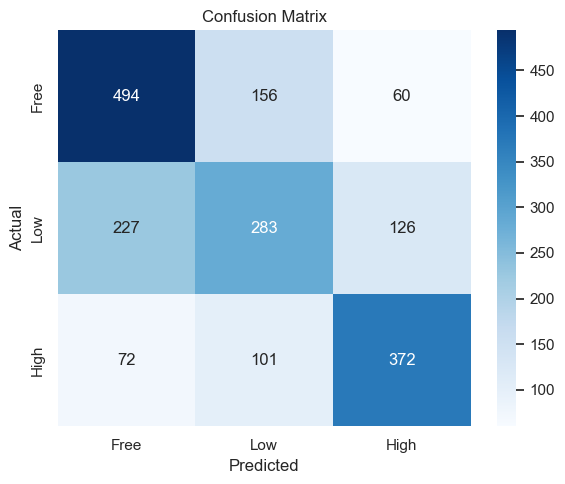

In [99]:
# Initialize the model
xgb_clf = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='mlogloss')

# Fit to training data
xgb_clf.fit(X_train, y_train)

# Make predictions
train_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Accuracy: 0.818342151675485
Test Accuracy: 0.6308831306187203

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.821     0.877     0.848      2222
         1.0      0.806     0.723     0.762      1869
         2.0      0.828     0.849     0.838      1579

    accuracy                          0.818      5670
   macro avg      0.818     0.816     0.816      5670
weighted avg      0.818     0.818     0.817      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.633     0.725     0.676       710
         1.0      0.568     0.447     0.500       636
         2.0      0.683     0.723     0.702       545

    accuracy                          0.631      1891
   macro avg      0.628     0.632     0.626      1891
weighted avg      0.625     0.631     0.624      1891



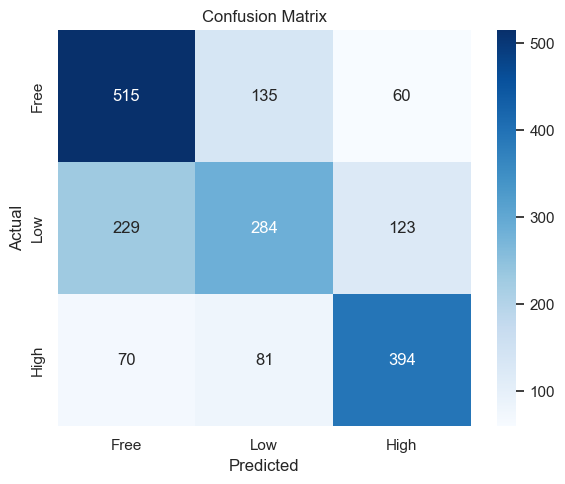

In [100]:
# Parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(2, 8),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.4)
}

# Model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Random search
rscv = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy', 
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit
rscv.fit(X_train, y_train)

# Best model
best_xgb = rscv.best_estimator_

# Predict
train_preds = best_xgb.predict(X_train)
test_preds = best_xgb.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')



### AdaBoostClassifier

Train Accuracy: 0.5786596119929454
Test Accuracy: 0.5510312004230565

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.630     0.668     0.648      2222
         1.0      0.455     0.445     0.450      1869
         2.0      0.651     0.612     0.631      1579

    accuracy                          0.579      5670
   macro avg      0.578     0.575     0.576      5670
weighted avg      0.578     0.579     0.578      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.581     0.663     0.619       710
         1.0      0.425     0.385     0.404       636
         2.0      0.647     0.598     0.622       545

    accuracy                          0.551      1891
   macro avg      0.551     0.549     0.548      1891
weighted avg      0.548     0.551     0.548      1891



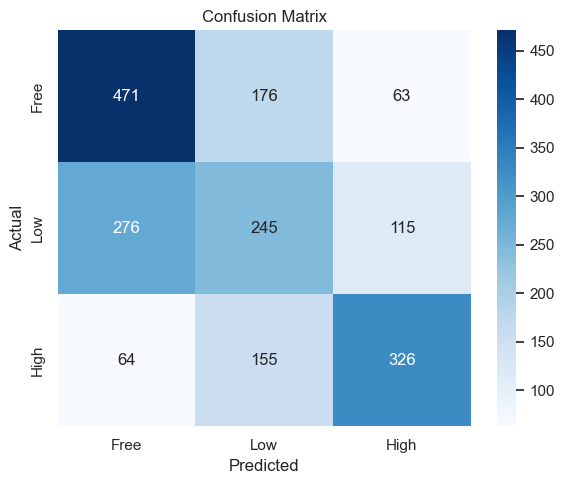

In [101]:
# Initialize model
ada_clf = AdaBoostClassifier(random_state=1)

# Fit model
ada_clf.fit(X_train, y_train)

# Make predictions
train_preds = ada_clf.predict(X_train)
test_preds = ada_clf.predict(X_test)

# Evaluate performance
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Accuracy: 0.6779541446208113
Test Accuracy: 0.5980962453728186

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.715     0.757     0.735      2222
         1.0      0.594     0.541     0.567      1869
         2.0      0.713     0.728     0.720      1579

    accuracy                          0.678      5670
   macro avg      0.674     0.676     0.674      5670
weighted avg      0.674     0.678     0.676      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.613     0.708     0.658       710
         1.0      0.488     0.409     0.445       636
         2.0      0.684     0.675     0.680       545

    accuracy                          0.598      1891
   macro avg      0.595     0.597     0.594      1891
weighted avg      0.592     0.598     0.592      1891



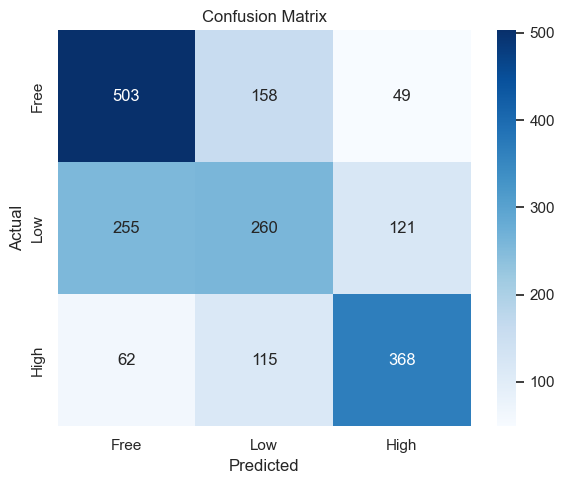

In [102]:
# Parameter grid
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 1.0),
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in range(1, 6)]
}

# Base AdaBoost model
ada = AdaBoostClassifier(random_state=1)

# RandomizedSearchCV
rscv = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=1,
    verbose=1,
    n_jobs=-1
)

# Fit to data
rscv.fit(X_train, y_train)

# Best estimator
best_ada = rscv.best_estimator_

# Predictions
train_preds = best_ada.predict(X_train)
test_preds = best_ada.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

## Linear & Distance-based model

In [103]:
# Select target variable
y = linear_games_df['IAPClass']
X = pca_df
# pca_df

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1
)

### Logistic Regression 

Train Accuracy: 0.5858906525573192
Test Accuracy: 0.565309360126917

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.653     0.639     0.646      2222
         1.0      0.487     0.407     0.444      1869
         2.0      0.590     0.723     0.650      1579

    accuracy                          0.586      5670
   macro avg      0.577     0.590     0.580      5670
weighted avg      0.581     0.586     0.580      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.603     0.620     0.611       710
         1.0      0.466     0.362     0.407       636
         2.0      0.598     0.732     0.658       545

    accuracy                          0.565      1891
   macro avg      0.556     0.571     0.559      1891
weighted avg      0.555     0.565     0.556      1891



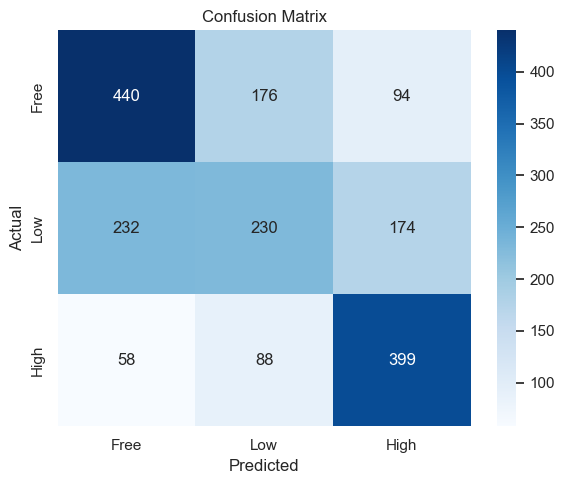

In [104]:
# Initialize model
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)

# Fit
log_clf.fit(X_train, y_train)

# Predict
train_preds = log_clf.predict(X_train)
test_preds = log_clf.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ka/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag

Train Accuracy: 0.5901234567901235
Test Accuracy: 0.5684822845055526

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.661     0.640     0.650      2222
         1.0      0.488     0.418     0.450      1869
         2.0      0.596     0.724     0.654      1579

    accuracy                          0.590      5670
   macro avg      0.582     0.594     0.585      5670
weighted avg      0.586     0.590     0.585      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.605     0.624     0.614       710
         1.0      0.470     0.365     0.411       636
         2.0      0.602     0.734     0.661       545

    accuracy                          0.568      1891
   macro avg      0.559     0.574     0.562      1891
weighted avg      0.559     0.568     0.559      1891



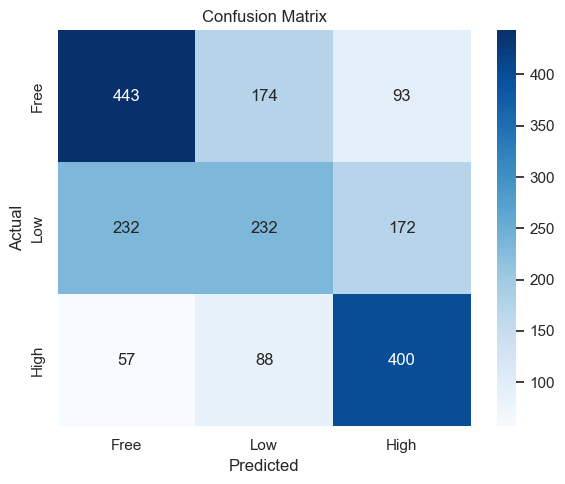

In [105]:
# Define parameter distribution
param_dist = {
    'C': loguniform(1e-4, 1e2),            
    'solver': ['lbfgs', 'saga'],      
    'penalty': ['l2'],                        
    'class_weight': ['balanced', None],     
    'max_iter': [1000, 2000]
}

# Initialize base model
log_clf = LogisticRegression(random_state=1)

# RandomizedSearchCV setup
rscv = RandomizedSearchCV(
    estimator=log_clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit to data
rscv.fit(X_train, y_train)

# Best model
best_log = rscv.best_estimator_

# Predict
train_preds = best_log.predict(X_train)
test_preds = best_log.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

Train Accuracy: 0.6121693121693121
Test Accuracy: 0.5795875198307774

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.678     0.644     0.660      2222
         1.0      0.520     0.464     0.491      1869
         2.0      0.620     0.743     0.676      1579

    accuracy                          0.612      5670
   macro avg      0.606     0.617     0.609      5670
weighted avg      0.610     0.612     0.609      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.613     0.620     0.616       710
         1.0      0.499     0.407     0.448       636
         2.0      0.607     0.728     0.662       545

    accuracy                          0.580      1891
   macro avg      0.573     0.585     0.576      1891
weighted avg      0.573     0.580     0.573      1891



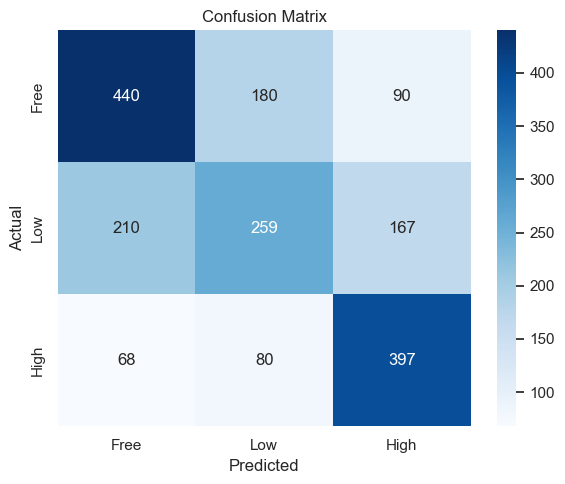

In [106]:
# Initialize model
svc_clf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=1)

# Fit
svc_clf.fit(X_train, y_train)

# Predict
train_preds = svc_clf.predict(X_train)
test_preds = svc_clf.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Accuracy: 0.6264550264550265
Test Accuracy: 0.5732416710735061

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.711     0.637     0.672      2222
         1.0      0.534     0.492     0.512      1869
         2.0      0.622     0.771     0.688      1579

    accuracy                          0.626      5670
   macro avg      0.622     0.633     0.624      5670
weighted avg      0.628     0.626     0.624      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.610     0.601     0.606       710
         1.0      0.481     0.398     0.435       636
         2.0      0.608     0.741     0.668       545

    accuracy                          0.573      1891
   macro avg      0.566     0.580     0.570      1891
weighted avg      0.566     0.573     0.566      1891



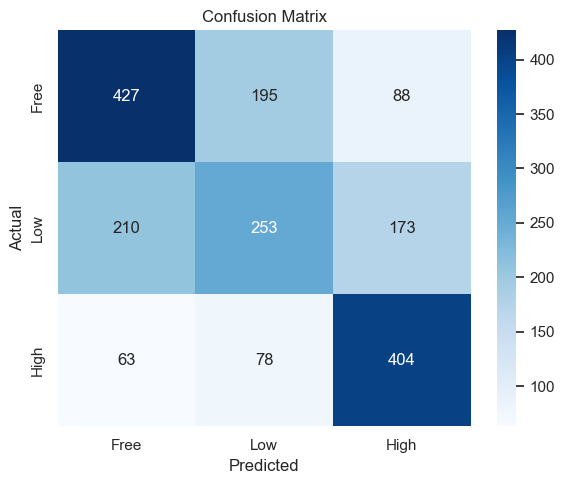

In [107]:
# Define parameter distribution
param_dist = {
    'C': loguniform(1e-2, 1e2),
    'gamma': loguniform(1e-4, 1e-1),
    'kernel': ['rbf', 'poly'],     
    'class_weight': ['balanced'],
    'probability': [True]          
}

# Initialize base model
svc = SVC(random_state=1)

# RandomizedSearchCV setup
rscv = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
rscv.fit(X_train, y_train)

# Best estimator
best_svc = rscv.best_estimator_

# Predict
train_preds = best_svc.predict(X_train)
test_preds = best_svc.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

Train Accuracy: 0.6962962962962963
Test Accuracy: 0.5621364357482813

Train Classification Report:
               precision    recall  f1-score   support

         0.0      0.682     0.823     0.746      2222
         1.0      0.660     0.567     0.610      1869
         2.0      0.768     0.671     0.716      1579

    accuracy                          0.696      5670
   macro avg      0.703     0.687     0.691      5670
weighted avg      0.698     0.696     0.693      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.550     0.697     0.615       710
         1.0      0.478     0.392     0.430       636
         2.0      0.679     0.585     0.629       545

    accuracy                          0.562      1891
   macro avg      0.569     0.558     0.558      1891
weighted avg      0.563     0.562     0.557      1891



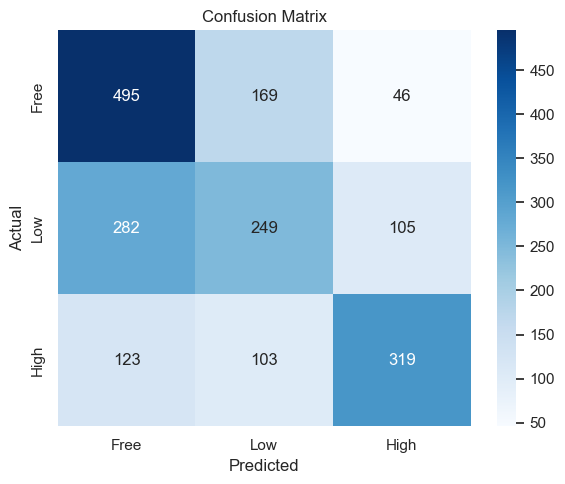

In [108]:
# Initialize model
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit
knn_clf.fit(X_train, y_train)

# Predict
train_preds = knn_clf.predict(X_train)
test_preds = knn_clf.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train Accuracy: 1.0
Test Accuracy: 0.5716552088841883

Train Classification Report:
               precision    recall  f1-score   support

         0.0      1.000     1.000     1.000      2222
         1.0      1.000     1.000     1.000      1869
         2.0      1.000     1.000     1.000      1579

    accuracy                          1.000      5670
   macro avg      1.000     1.000     1.000      5670
weighted avg      1.000     1.000     1.000      5670


Test Classification Report:
               precision    recall  f1-score   support

         0.0      0.576     0.642     0.608       710
         1.0      0.478     0.398     0.434       636
         2.0      0.651     0.683     0.667       545

    accuracy                          0.572      1891
   macro avg      0.569     0.574     0.570      1891
weighted avg      0.565     0.572     0.566      1891



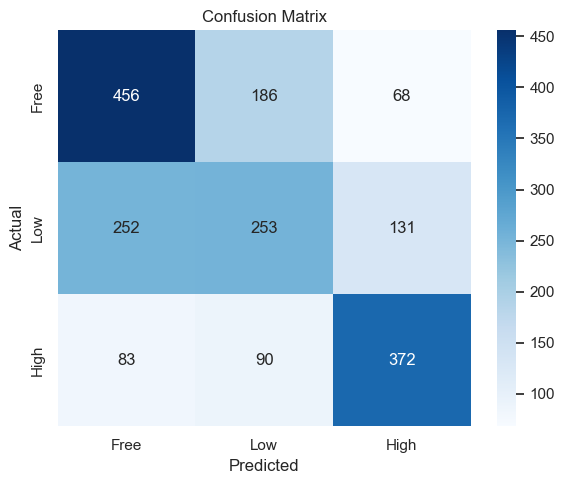

In [109]:
# Define parameter space
param_dist = {
    'n_neighbors': randint(3, 30), 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]                          
}

# Initialize base model
knn = KNeighborsClassifier()

# RandomizedSearchCV setup
rscv = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
rscv.fit(X_train, y_train)

# Best estimator
best_knn = rscv.best_estimator_

# Predict
train_preds = best_knn.predict(X_train)
test_preds = best_knn.predict(X_test)

# Evaluate
print_model_performance(y_train, y_test, train_preds, test_preds, modelType='classifier')

## Final Model Comparisons